# PySpice_EyePoint_CurveTracer
## часть проекта по восстановлению электронной схемы характериографом

## https://github.com/vasily84/PySpice_CurveTracer 


### Необходимы - python3.x, sklearn,PySpice

### необходимые библиотеки -
### PySpice - симуляция электронных схем из Python
https://pyspice.fabrice-salvaire.fr/ 

https://github.com/FabriceSalvaire/PySpice

### scikit-learn библиотека машинного обучения
https://scikit-learn.org/stable/index.html

## Как использовать?
### Необходимо задать рабочую папку программы в переменной FILEBASE_ROOT ( ячейка ниже). 
### Варианты запуска программы :

* Первый запуск - Папка задана, но не существует: программа создаст папку и скачает библиотеку spice компонентов из github, затем сгенерирует синтетические данные для схем, описанных в коде и построит модели машинного обучения для них. Для каждой модели создается отдельная папка внутри FILEBASE_ROOT. Туда же пишется её .pickle образ. При последующих запусках модели будут подгружаться с диска.


* Второй и прочие запуски - (папка FILEBASE_ROOT содержит библиотеку spice компонентов и дополнительные папки с обученными моделями) обученные модели загружаются с диска.


* При необходимости переобучить модель - можно удалить файл модели .pickle из ее подпапки или всю её подпапку - при следующем запуске ноутбука модель будет перетренирована.


* При необходимости перенести ноутбук целиком на другой компьютер можно скопировать папку FILEBASE_ROOT и указать правильные пути к ней, но следует помнить о возможной несовместимости .pickle объектов для разных версий питона и библиотек.

### Код написан последовательно сверху вниз-
### для тестирования и исследовательских целей удобнее всего запускать ноутбук целиком Menu->Kernel->Restart & Run All, помещая необходимый дополнительный код в самые нижние ячейки ноутбука, и затем дописывая и запуская ячейки


In [1]:
FILEBASE_ROOT = 'E:\EyePoint' # путь к рабочей папке программы

In [7]:
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
import itertools
from sklearn import __version__ as sk_version
from scipy.signal import resample

import PySpice
import PySpice.Logging.Logging as Logging
from PySpice.Spice.Netlist import Circuit
from PySpice.Spice.Library import SpiceLibrary
from PySpice.Doc.ExampleTools import find_libraries
from PySpice.Unit import *

import os
import uuid
import random
import requests
import zipfile
import json

import warnings
warnings.filterwarnings('once')

plt.style.use('seaborn')
plt.rcParams["figure.figsize"] = (10,8)

logger = Logging.setup_logging()
PySpice.show_version()
print('sklearn version '+sk_version)

Circuit_Set = set() # Множество всех схем 

# нижние и верхние пределы величин номиналов радиоэлементов 
# килоОмы
R_SMALL = 1e-5 # 
R_HUGE = 100 #
# микроФарады
C_SMALL = 1e-5
C_HUGE = 100
# микроГенри
L_SMALL = 100
L_HUGE = 1e-3

# размер выборки, применяемы при обучении моделей 
REGRESSION_SAMPLES_COUNT = 500 # None
CLASSIFICATION_SMAPLES_COUNT = 100 # None

PySpice Version 1.4.3
sklearn version 1.0.2


C:\ProgramData\Anaconda3\lib\site-packages\PySpice\Logging\Logging.py:47: ResourceWarning: unclosed file <_io.TextIOWrapper name='C:\\ProgramData\\Anaconda3\\lib\\site-packages\\PySpice\\Config\\logging.yml' mode='r' encoding='cp1251'>
  logging_config = yaml.load(open(logging_config_file_name, 'r'), Loader=yaml.SafeLoader)


### проверяем пути к рабочей папке, при необходимости подгружаем spice библиотеки компонентов и обученные модели с github

In [10]:
def download_and_unzip(filePath):
    print('downloading started..')
                       
    url = 'https://github.com/vasily84/PySpice_CurveTracer/raw/main/spice_library.zip'
    # Downloading the file by sending the request to the URL
    req = requests.get(url)

    zipName = os.path.join(filePath,'temp.zip')
    print('from '+str(url)+'\ndownloaded '+str(len(req.content))+' bytes')
    
    # Writing the file to the local file system
    with open(zipName,'wb') as output_file:
        output_file.write(req.content)
    print('downloading completed, UnZip started..')
    
    # unzip 
    with zipfile.ZipFile(zipName, 'r') as zip_ref:
        zip_ref.extractall(filePath)
        
    os.remove(zipName)
    print('UnZip completed..')
    
    
# проверяем пути к рабочей папке,
# при необходимости подгружаем spice библиотеки компонентов
# и обученные модели с github
if not os.path.exists(FILEBASE_ROOT):
    os.makedirs(FILEBASE_ROOT)
    download_and_unzip(FILEBASE_ROOT)

print('\nsimulation dataset on:\n'+FILEBASE_ROOT)

libraries_path = os.path.join(FILEBASE_ROOT,'spice_library')
print('\nspice models library on:\n'+libraries_path)
spice_library = SpiceLibrary(libraries_path)
print(spice_library['1N4148'])


simulation dataset on:
E:\EyePoint

spice models library on:
E:\EyePoint\spice_library
E:\EyePoint\spice_library\diode\switching\1N4148.lib


### код CreateCVC базируется на библиотеке MySpice
https://github.com/LukyanovM/MySpice

используем эту библиотеку, ибо она максимально близко имитирует прибор
EyePoint https://eyepoint.physlab.ru/ru/

In [11]:
class CurveTracer_Settings():
    """ EyePoint hardware settings struct"""
    def __init__(self,F=100,V=5.,Rcs=4750.,SNR=70.0,lendata=100,cycle=3,json=None):
        self.F = F
        self.V = V
        self.Rcs = Rcs
        self.SNR = SNR
        self.lendata = lendata
        self.cycle = cycle
        if json is not None:
            self.from_json(json)
    
    def to_numpy(self):
        arr = np.array([self.F, self.V, self.Rcs, self.SNR, self.lendata, self.cycle])
        return arr
    
    def from_numpy(self,arr):
        self.F = arr[0]
        self.V = arr[1]
        self.Rcs = arr[2]
        self.SNR = arr[3]
        self.lendata = int(arr[4])
        self.cycle = int(arr[5])
        return self
        
    def __str__(self):
        s = 'F='+str(self.F)+' V='+str(self.V)+' lendata='+str(self.lendata)+' Rcs='+str(self.Rcs)+' cycle='+str(self.cycle)+' SNR='+str(self.SNR)
        return s
    
    def __eq__(self,obj):
        """ сравниваем по критерию - частота, напряжение, число точек,вн.сопротивление """
        lendata_ok = (self.lendata==obj.lendata)
        F_ok = abs(self.F-obj.F) <= 0.1 # точность сравнения 0.1 Гц
        V_ok = abs(self.V-obj.V) <= 0.1 # точность сравнения 0.1 Вольт
        Rcs_ok = abs(self.Rcs-obj.Rcs) <=0.1 # точность 0.1 Ом
        return (lendata_ok and F_ok and V_ok)
    
    def __hash__(self):
        """ поддержка hash для работы с множествами"""
        return hash((self.F,self.V,self.lendata,self.Rcs))
    
    def from_json(self,jsonRec):
        #print(jsonRec['iv_curves'][0]['measurement_settings'])
        self.F = jsonRec['iv_curves'][0]['measurement_settings']['probe_signal_frequency']
        self.V = jsonRec['iv_curves'][0]['measurement_settings']['max_voltage']
        self.Rcs = jsonRec['iv_curves'][0]['measurement_settings']['internal_resistance']
        sr = jsonRec['iv_curves'][0]['measurement_settings']['sampling_rate']
        self.lendata = sr//self.F
        return self
        

def CreateCVC(circuit,ct):
    """ просимулировать схему в PySpice. circuit - схема, ct - настройки симуляции"""
    cycle = ct.cycle
    lendata = ct.lendata
    period = 1 / ct.F
    rms_voltage = ct.V / np.sqrt(2)
    # добавляем испытательный щуп в схему
    circuit.R('cs', 'input', 'input_dummy', ct.Rcs)
    circuit.AcLine('Current', circuit.gnd, 'input_dummy', rms_voltage=rms_voltage, frequency=ct.F)
    
    simulator = circuit.simulator()
    analysis = simulator.transient(step_time=period / lendata, end_time=period * cycle)
    analysis.input_dummy = analysis.input_dummy[len(analysis.input_dummy)-lendata:len(analysis.input_dummy)]
    analysis.VCurrent = analysis.VCurrent[len(analysis.VCurrent)-lendata:len(analysis.VCurrent)]
# Расчитываем шум независмо для тока и напряжения исходя из среднеквадратичных значений и одинакового SNR
    avg_V_db = 10 * np.log10(np.mean(np.array(analysis.input_dummy, dtype=float) ** 2))
    avg_Vnoise_db = avg_V_db - ct.SNR
    Vnoise = np.random.normal(0, np.sqrt(10 ** (avg_Vnoise_db / 10)), len(analysis.input_dummy))
    analysis.input_dummy = np.array(analysis.input_dummy, dtype=float) + Vnoise
    avg_I_db = 10 * np.log10(np.mean(np.array(analysis.VCurrent, dtype=float) ** 2))
    avg_Inoise_db = avg_I_db - ct.SNR
    Inoise = np.random.normal(0, np.sqrt(10 ** (avg_Inoise_db / 10)), len(analysis.VCurrent))
    analysis.VCurrent = np.array(analysis.VCurrent, dtype=float) + Inoise
    # удаляем испытательный щуп из схемы
    circuit.Rcs.detach()
    circuit.VCurrent.detach()
    return analysis

class CAnalysis():
    def __init__(self,VCurrent=None,input_dummy=None,json=None):
        self.VCurrent = VCurrent
        self.input_dummy = input_dummy
        if json is not None:
            self.from_json(json)
    
    def from_json(self,jsonRec):
        self.VCurrent = jsonRec["iv_curves"][0]["currents"]
        self.input_dummy = jsonRec["iv_curves"][0]["voltages"]
        return self
        
def load_JSON_Records(filePath):
    """ загрузка с диска набора снятых прибором данных - самого сигнала и параметров его съемки """
    with open(filePath, "r") as jfile:
        J = json.load(jfile)
    return J["elements"][0]["pins"]

def plot_analysis_IV(analysis,label='',ax=None):
    """ plot I(V) curve for analysis """
    if ax is None:
        plt.plot(analysis.input_dummy, analysis.VCurrent,label=label)
        plt.title('I(V)')
        plt.xlabel('Напряжение [В]')
        plt.ylabel('Сила тока [А]')
        return
    ax.plot(analysis.input_dummy, analysis.VCurrent,label=label)
    ax.set_title('I(V)')
    ax.set_xlabel('Напряжение [В]')
    ax.set_ylabel('Сила тока [А]')
    

Cоставим множество из доступных варианов режимов работы прибора

In [12]:
# варианты настройки пробора по умолчанию - перечисляем известные врукопашную 
ct_List = list()
ct = CurveTracer_Settings(F=1.,V=3.3,lendata=100,Rcs=475.)
ct_List.append(ct)
ct = CurveTracer_Settings(F=100.,V=5.,lendata=100,Rcs=4750.)
ct_List.append(ct)
ct = CurveTracer_Settings(F=100_000,V=12.,lendata=20,Rcs=47500.)
ct_List.append(ct)

try: # просканируем папку, добавим оттуда варианты настройки прибора
    path_json = os.path.join(FILEBASE_ROOT,'RealSignalFolder')
    fileList = [f for f in os.listdir(path_json) if f.endswith('.json')]
    
    # просмотрим доступные файлы, составим множество из конфигураций прибора
    for f1 in fileList:
        ff = os.path.join(FILEBASE_ROOT,'RealSignalFolder',f1)
        jRecs = load_JSON_Records(ff)
        for j in jRecs:
            ct = CurveTracer_Settings(json=j)
            #analysis = CAnalysis(json=j)
            ct_List.append(ct)
finally:
    # удалим дубликаты
    ct_List_uniq = []
    for ct in ct_List:
        if ct not in ct_List_uniq:
            ct_List_uniq.append(ct)
    ct_List = ct_List_uniq
    print('list of curve tracer settings:')
    for ct in ct_List:
         print(ct)


list of curve tracer settings:
F=1.0 V=3.3 lendata=100 Rcs=475.0 cycle=3 SNR=70.0
F=100.0 V=5.0 lendata=100 Rcs=4750.0 cycle=3 SNR=70.0
F=100000 V=12.0 lendata=20 Rcs=47500.0 cycle=3 SNR=70.0


#### пример использования CreateCVC

In [13]:
%%script false
circuit = Circuit('RD')
circuit.include(spice_library['1N4148'])
circuit.R(1,'input',1,10@u_kOhm)
circuit.X('D1', '1N4148', 1, circuit.gnd)
circuit.R(2,'input',circuit.gnd,20@u_kOhm)

analysis = CreateCVC(circuit,CurveTracer_Settings())
        
plt.plot(analysis.input_dummy, analysis.VCurrent)
plt.xlabel('Напряжение [В]')
plt.ylabel('Сила тока [А]')
plt.show()

Couldn't find program: 'false'


### как построена база?
каждой схеме соответствует папка, в которой хранятся файлы массивов симуляции c номиналами схемы и параметрами прибора,и circuit файл - информация о самой схеме

In [14]:
def save_cir_analysis(fileName,circuit_params,curve_params,analysis):
    """ save circuit nominals,curve tracer parameters, voltage and current arrays to file"""
    with open(fileName, 'wb') as f:
        np.save(f,circuit_params)
        np.save(f,curve_params)
        np.save(f,analysis.VCurrent)
        np.save(f,analysis.input_dummy)
    
def make_sure_path(path_title):
    """ create path if path not exist, return full path """
    dirName = os.path.join(FILEBASE_ROOT,path_title)
    if not os.path.exists(dirName):
        os.makedirs(dirName)
    return dirName

def save_circuit(dirName,circuit):
    """ save sample circuit on disk """
    fileName = os.path.join(dirName,circuit.title+'.cir')
    write(str(circuit))
        
        
def load_circuit_dataset(path_dataset,ct=None,shuffle=True,max_files=None):
    """ load dataset from circuit folder.
    return X,y """
    fileList = [f for f in os.listdir(path_dataset) if f.endswith('.npy')]
    
    if shuffle: 
        random.shuffle(fileList)
        
    if max_files is None:
        max_files = len(fileList)
    
    X_data,y_data=[],[]
    fileCount = 0
    with tqdm(total=max_files) as pbar:
        for fileName in fileList: # process files
            with open(os.path.join(path_dataset,fileName), 'rb') as f:
                circuit_params = np.load(f)
                curve_params = np.load(f)
                VCurrent = np.load(f)
                input_dummy = np.load(f)  

                if not ct is None: 
                    ct0 = CurveTracer_Settings().from_numpy(curve_params)
                    if not (ct0==ct):
                        continue # пропускаем сигналы с неподходящими параметрами

            # append data to arrays
            y_data.append(circuit_params)
            X_data.append([VCurrent,input_dummy])
            
            fileCount +=1
            pbar.update(1)

            if fileCount>=max_files:
                break

    return np.array(X_data),np.array(y_data)

def remove_circuit_dataset(path_dataset):
    fileList = [f for f in os.listdir(path_dataset) if f.endswith('.npy')]
    
    for f in fileList:
        os.remove(f)
    

## препроцессор данных для моделей -
### делает преобразование фурье, прореживание и прочие манипуляции со входными сигналами

#### Мотивация к добавлению в признаковое пространство конкретных алгебраических величин (закон Ома):

Ток $I=V/R$

Сопротивление $R=V/I$

Проводимость $\sigma=1/R=I/V$

Напряжение на конденсаторе $V=C*Q$

Заряд конденсатора $Q=\int Idt \sim \sum {I}$ 

Емкость конденсатора $C=V/Q$ или $C \sim V/\sum {I}$

Диф. сопротивление $R_d= \frac {\Delta {V}} {\Delta{I}}$

Диф. Проводимость $\sigma_d=1/R_d=\Delta {I}/\Delta {V}$

Напряжение на индуктивности $ V = -L \frac {\Delta{I}} {\Delta{t}} \sim L\Delta{I}$

Величина индуктивности $L \sim \frac {V} {\Delta{I}}$

##### Итого - параметры R, C, L линейно связаны с сигналами V, I, их производными (изменениями от точке к точке) и интегралами (суммами)


#### Мотивация к использованию логарифмов:

$\log {(AB)} = \log {A}+\log {B} $

$\log {\frac {A} {B}} = \log {A}-\log{B}$

##### Итого - можно взять логарифмы от исходных сигналов, их производных и интегралов, и линейная модель их свяжет с логарифмами искомых параметров R, C, L. 

In [15]:
from sklearn.preprocessing import FunctionTransformer,StandardScaler
from scipy.fft import rfft

def my_xgb_transform_function(X):
    """ feature engineering on raw analysis signal data.
    Transformations - fft image, input signal resampling etc.""" 
    Xa = []
    for x in X:
        I_signal = x[:len(x)//2] # current      
        V_signal = x[len(x)//2:] # input voltage - not use
        I_fft = rfft(I_signal)
        I_fft = I_fft[:20] # use only first 20 points on freq domain
        I_abs = np.abs(I_fft)
        I_angle = np.angle(I_fft)
        I_real = np.real(I_fft)
        I_imag = np.imag(I_fft)
        
        V_fft = rfft(V_signal)
        V_fft = V_fft[:20] # use only first 20 points on freq domain
        V_abs = np.abs(V_fft)
        V_angle = np.angle(V_fft)
        V_real = np.real(V_fft)
        V_imag = np.imag(V_fft)

        x1 = np.hstack((x,I_abs,I_angle,I_real,I_imag,V_abs,V_angle,V_real,V_imag))
        Xa.append(x1)
        
    return np.array(Xa)

def my_rfft_transform_function(X):
    """ feature engineering on raw analysis signal data.
    Transformations - fft image, input signal resampling etc.""" 
    Xa = []
    for x in X:
        I_signal = x[:len(x)//2] # current      
        V_signal = x[len(x)//2:] # input voltage - not use
        I_fft = rfft(I_signal)
        
        I_abs = np.abs(I_fft)
        I_angle = np.angle(I_fft)
        I_real = np.real(I_fft)
        I_imag = np.imag(I_fft)
        
        V_fft = rfft(V_signal)
        
        V_abs = np.abs(V_fft)
        V_angle = np.angle(V_fft)
        V_real = np.real(V_fft)
        V_imag = np.imag(V_fft)

        x1 = np.hstack((I_abs,I_angle,I_real,I_imag,V_abs,V_angle,V_real,V_imag))
        Xa.append(x1)
        
    return np.array(Xa)

def my_linear_transform_function(X):
    """ feature engineering on raw analysis signal data.
    Transformations - fft image, input signal resampling etc.""" 
    Xa = []
    for x in X:
        I_signal = x[:len(x)//2] # current      
        V_signal = x[len(x)//2:] # input voltage - not use
        Q_signal = np.cumsum(I_signal)
        dI_signal = np.diff(I_signal)
        dV_signal = np.diff(V_signal)
        
        x1 = np.hstack((I_signal,V_signal,Q_signal,dI_signal,dV_signal))
        Xa.append(x1)
        
    return np.array(Xa)

MyXGBTransformer = FunctionTransformer(my_xgb_transform_function)
MyRfftTransformer = FunctionTransformer(my_rfft_transform_function)
MyLinearTransformer = FunctionTransformer(my_linear_transform_function)

## базовый класс схем

In [16]:
import pickle
from scipy.optimize import minimize
from sklearn.metrics import mean_squared_error
from sklearn.linear_model import LinearRegression, LassoCV,RidgeCV,Lasso,Ridge
from sklearn.svm import SVR
from sklearn.ensemble import GradientBoostingRegressor,HistGradientBoostingRegressor
from sklearn.ensemble import StackingRegressor,ExtraTreesRegressor
from sklearn.multioutput import MultiOutputRegressor
from sklearn.pipeline import make_pipeline,Pipeline
from sklearn.model_selection import train_test_split,GridSearchCV
from sklearn.neural_network import MLPRegressor
from copy import deepcopy

class BaseCircuitModel():
    """ base class for circuit models. Provide training, data preprocessing,
    prediction for nominal values """
    def __init__(self,title='baseAbstract',modelDir=None,modelName=None,estimator=None,ct=None):
        self.title = title
        self.estimator = estimator
        self.modelDir = os.path.join(FILEBASE_ROOT,self.title) if (modelDir is None) else modelDir  
        make_sure_path(self.modelDir)
        self.modelName = title+'.pickle' if (modelName is None) else modelName   
        self.modelFileName = os.path.join(self.modelDir,self.modelName)
        self.optimize_save_flag = False
        
        if ct is None:
            ct = CurveTracer_Settings()
            
        # deepcopy необходим, т.к. при загрузке с диска self.ct пересоздается 
        self.ct = deepcopy(ct) 
        
        try:
            self.load_model()
            return 
        except OSError as e:
            print(e)
            
        print('\nrebuild model ...')
        self.build_model()
        
    
    def load_model(self):
        with open(self.modelFileName, "rb") as f:
                self.model = pickle.load(f)
                self.rank = self.model.rank # number of circuit variative nominals
                self.ct = CurveTracer_Settings().from_numpy(self.model.ct)
        
    def save_model(self):
        with open(self.modelFileName, "wb") as f:
                self.model.rank = self.rank
                self.model.ct = self.ct.to_numpy()
                pickle.dump(self.model, f)
        
    def write_dataset(self,Xvals):
        """ circuit batch simulation over params Xvals"""
        for xval in tqdm(Xvals): # walk over nominals in circuit and create I/V curves
            cir_params = np.array(xval)
            circuit = self.build_circuit(cir_params)
            analysis = CreateCVC(circuit,ct=self.ct)
            fileName = os.path.join(self.modelDir,uuid.uuid4().hex+'.npy')
            save_cir_analysis(fileName,cir_params,self.ct.to_numpy(),analysis)

    def load_dataset(self):
        """ load dataset from disk"""
        X_data,y_data = load_circuit_dataset(self.modelDir,ct=self.ct,max_files=REGRESSION_SAMPLES_COUNT)
        ADim = X_data.shape[0]
        X_data = X_data.reshape(ADim,-1)
        if self.rank==1: # fit shape 1d regression or Nd regression 
            y_data = y_data.reshape(-1)
        else:
            y_data = y_data.reshape(ADim,-1)
            
        return X_data,y_data
        
    def build_model(self,save_model=True, test_model=False ): 
        print('dataset for model '+self.title+' is loading, please wait..')
        
        if self.estimator is None:
            baseEstimator = HistGradientBoostingRegressor()
            
            if self.rank>1: # multioutput
                reg1 = make_pipeline(MyRfftTransformer,Lasso())
                reg2 = make_pipeline(MyLinearTransformer,Ridge())
                reg3 = make_pipeline(MyXGBTransformer,HistGradientBoostingRegressor())
                #reg4 = make_pipeline(MyLinearTransformer,SVR(kernel='linear'))
                reg5 = make_pipeline(MyLinearTransformer,HistGradientBoostingRegressor())
                estimators = [('rfft_lasso',reg1),('linear_ridge',reg2),('gbr',reg3),
                             ('linear_gbr',reg5)]
                self.model = MultiOutputRegressor(StackingRegressor(estimators=estimators))
            else: #
                reg1 = make_pipeline(MyRfftTransformer,Lasso())
                reg2 = make_pipeline(MyLinearTransformer,RidgeCV())
                reg3 = make_pipeline(MyXGBTransformer,HistGradientBoostingRegressor())
                reg4 = make_pipeline(MyLinearTransformer,SVR(kernel='linear'))
                reg5 = make_pipeline(MyRfftTransformer,ExtraTreesRegressor())
                reg6 = make_pipeline(MyLinearTransformer,MLPRegressor(max_iter=2000,hidden_layer_sizes=(5)))
                estimators = [('rfft_lasso',reg1),('linear_ridge',reg2),('gbr',reg3),
                             ('linear_svr',reg4),('rfft_xgb',reg5),('linear_weak_mlp',reg6)]
                
                self.model = StackingRegressor(estimators=estimators)
        else:
            self.model = self.estimator
        
        try:
            X_data,y_data = self.load_dataset()
        except BaseException as e:
            print(e)
            print('rebuild dataset ...')
            self.rebuild_dataset()
            X_data,y_data = self.load_dataset()
        
        X_train,X_test,y_train,y_test = train_test_split(X_data,y_data)
        print('model settings '+str(self.ct))
        print('model '+self.title+' is training, please wait..')
        self.model.fit(X_train,y_train)
        print('model R2score = '+str(self.model.score(X_test,y_test)))
        
        self.model.rank = self.rank
        if save_model:
            self.save_model()
            self.load_model()
        
        if test_model:
            print('test_model() routine for '+self.title+' model:')
            self.test_model()
    
    def test_model(self):
        print('!!WARNING : test_model() routine for '+self.title+' model not implemented')
            
    def predict_from_model(self,analysis0,start_minimization=False):
        """ predict X values for circuit, best fitted to analysis0 """
        if not len(analysis0.VCurrent)==self.ct.lendata:
            print('len(A)='+str(len(analysis0.VCurrent)),end='')
            print(' len(B)='+str(self.ct.lendata))
            print('do resampling')
            VCurrent = resample(analysis0.VCurrent,self.ct.lendata)
            input_dummy = resample(analysis0.input_dummy,self.ct.lendata)
            X = np.array([VCurrent,input_dummy]).reshape(-1)
        else:
            X = np.array([analysis0.VCurrent,analysis0.input_dummy]).reshape(-1)
        
        a = self.model.predict([X])[0]
        if start_minimization:
            a,_ = self.optimize_from_X(analysis0,a)
        
        return a
        
    def misfit(self,analysis0, Xvals=None,start_minimization=False):
        """ calculate mse for current from circuit from Xval simulation and from analysis"""
        if Xvals is None:
            Xvals = self.predict_from_model(analysis0)
        
        if start_minimization:
            Xvals,_ = self.optimize_from_X(analysis0,Xvals)
            
        circuit = self.build_circuit(Xvals)
        analysis1 = CreateCVC(circuit,self.ct)
            
        return self.analysis_cmp(analysis0, analysis1)
    
    def analysis_cmp(self,analysis0,analysis1):
        """ сравнить два сигнала. Опорный сигал всегда analysis0. Делает ресемплинг при необходимости, переходит в новый масштаб """
        len_0 = len(analysis0.VCurrent)
        len_1 = len(analysis1.VCurrent)
        
        if not len_0==len_1: # делаем ресемплинг на бОльшую длину
            print('do resample..')
            len_max = max(len_o,len_1)
            I_0 = resample(analysis0.VCurrent,len_max)
            I_1 = resample(analysis1.VCurrent,len_max)
            V_0 = resample(analysis0.input_dummy,len_max)
            V_1 = resample(analysis1.input_dummy,len_max)
        else:
            I_0 = np.copy(analysis0.VCurrent)
            I_1 = np.copy(analysis1.VCurrent)
            V_0 = np.copy(analysis0.input_dummy)
            V_1 = np.copy(analysis1.input_dummy)
            
        #norm_I = max(max(np.abs(I_0)),max(np.abs(I_1)))    
        norm_I = np.abs(I_0)+np.abs(I_1) 
        I_0 = I_0/norm_I
        I_1 = I_1/norm_I
        
        #norm_V = max(max(np.abs(V_0)),max(np.abs(V_1)))
        norm_V = np.abs(V_0)+np.abs(V_1)
        V_0 = V_0/norm_V
        V_1 = V_1/norm_V
        dist2_I = (I_0-I_1)**2
        dist2_V = (V_0-V_1)**2
        
        dist = np.sqrt(dist2_I+dist2_V)
        return np.mean(dist) # сравниваем по расстоянию в координатах ток-напряжение
        
    def _optimize_func(self,Xvals):      
        circuit = self.build_circuit(Xvals)
        analysis1 = CreateCVC(circuit,self.ct)
        
        if self.optimize_save_flag:
            fileName = os.path.join(self.modelDir,'o_'+uuid.uuid4().hex+'.npy')
            save_cir_analysis(fileName,Xvals,ct_default_settings.to_numpy(),analysis1)

        return self.analysis_cmp(self._analysis0,analysis1)

    def optimize_from_X(self,analysis0,Xvalues = None):
        if Xvalues is None:
            Xvalues = self.predict_from_model(analysis0).reshape(-1)
        self._analysis0 = analysis0 #
        
        #resX = spo.minimize(fitter_subroutine,Xargs,method='Powell',callback=fitter_callback, options={'maxfev':MAXFEV,'xtol':VALUES_TOLERANCE})    
        optimize_result = minimize(self._optimize_func,Xvalues,method='Powell',options={'maxiter':20_000})
        
        return (optimize_result.x, optimize_result)
        
    


### Реализация конкретных схем из резисторов, емкостей, индуктивностей и диодов 
## rank 1, rank 2

In [17]:
%%time
######################################################################

R_SMALL = 1e-5 # 
R_HUGE = 100 #
# микроФарады
C_SMALL = 1e-5
C_HUGE = 100
# микроГенри
L_SMALL = 100
L_HUGE = 1e-3

class R_circuit(BaseCircuitModel):
    def __init__(self,modelName=None,estimator=None,ct=None):
        self.rank = 1
        super().__init__('R',modelName=modelName,estimator=estimator,ct=ct)
            
    def build_circuit(self,Xvals): 
        if isinstance(Xvals, float):
            r1 = Xvals
        elif isinstance(Xvals, list):
            r1 = Xvals[0]
        else: # it is numpy array
            r1 = Xvals.item()
        r1 = np.abs(r1)
        circuit = Circuit('R')
        circuit.R(1,'input',circuit.gnd,r1@u_kOhm)
        return circuit
    
    def rebuild_dataset(self):
        self.write_dataset(np.random.uniform(R_SMALL,R_HUGE,size=50))
        self.write_dataset(np.random.uniform(R_SMALL,5,size=50))
        
        
    def test_model(self):
        print('actual r \t predicted r \t acc dr/r ')
        for r in np.array([0.1, 1, 1.1, 3., 10., 15., 22., 30., 50., 70., 75., 98., 100.]):
            analysis0 = CreateCVC(self.build_circuit(r),self.ct)
            x = self.predict_from_model(analysis0)
            acc = np.abs((x-r)/r)
            print(str(r),str(x),str(acc),sep='\t')
            
Circuit_Set.add(R_circuit('R1',ct=ct_List[0]))
Circuit_Set.add(R_circuit('R2',ct=ct_List[1]))
Circuit_Set.add(R_circuit('R3',ct=ct_List[2]))


######################################################################

class C_circuit(BaseCircuitModel):
    def __init__(self,modelName=None,estimator=None,ct=None):
        self.rank = 1
        super().__init__('C',modelName=modelName,estimator=estimator,ct=ct)
        
    def build_circuit(self,Xvals): 
        if isinstance(Xvals, float):
            c1 = Xvals
        elif isinstance(Xvals, list):
            c1 = Xvals[0]
        else: # it is numpy array
            c1 = Xvals.item()
        c1 = np.abs(c1)
        circuit = Circuit('C')
        circuit.C(1,'input',circuit.gnd,c1@u_uF)
        return circuit
    
    def rebuild_dataset(self):
        self.write_dataset(np.random.uniform(C_SMALL,C_HUGE,size=50))
        
    def test_model(self):
        print('actual c \t predicted c \t acc dc/c ')
        
        for c in np.array([0.1, 1, 1.1, 3., 10., 15., 22., 30., 50., 70., 75., 98., 100.]):
            analysis0 = CreateCVC(self.build_circuit(c),self.ct)
            x = self.predict_from_model(analysis0)
            acc = np.abs((x-c)/c)
            print(str(c),str(x),str(acc),sep='\t')
    
Circuit_Set.add(C_circuit('C1',ct=ct_List[0]))
Circuit_Set.add(C_circuit('C2',ct=ct_List[1]))
Circuit_Set.add(C_circuit('C3',ct=ct_List[2]))

    
######################################################################

class L_circuit(BaseCircuitModel):
    def __init__(self,modelName=None,estimator=None,ct=None):
        self.rank = 1
        super().__init__('L',modelName=modelName,estimator=estimator,ct=ct)
            
    def build_circuit(self,Xvals): 
        if isinstance(Xvals, float):
            l1 = Xvals
        elif isinstance(Xvals, list):
            l1 = Xvals[0]
        else: # it is numpy array
            l1 = Xvals.item()
        l1 = np.abs(l1)
        circuit = Circuit('L')
        circuit.L(1,'input',circuit.gnd,l1@u_uH)
        return circuit
    
    def rebuild_dataset(self):
        self.write_dataset(np.random.uniform(L_SMALL,L_HUGE,size=1000))
        
    def test_model(self):
        print('actual c \t predicted c \t acc dc/c ')
        
        for l in np.array([0.1, 1, 1.1, 3., 10., 15., 22., 30., 50., 70., 15., 398., 700.]):
            analysis0 = CreateCVC(self.build_circuit(l),self.ct)
            x = self.predict_from_model(analysis0)
            acc = np.abs((x-l)/l)
            print(str(l),str(x),str(acc),sep='\t')
        
Circuit_Set.add(L_circuit('L1',ct=ct_List[0]))
Circuit_Set.add(L_circuit('L2',ct=ct_List[1]))
Circuit_Set.add(L_circuit('L3',ct=ct_List[2]))

######################################################################

class DR_circuit(BaseCircuitModel):
    def __init__(self,modelName=None,estimator=None,ct=None):
        self.rank = 1
        super().__init__('DR',modelName=modelName,estimator=estimator,ct=ct)
            
    def build_circuit(self,Xvals): 
        if isinstance(Xvals, float):
            r1 = Xvals
        elif isinstance(Xvals, list):
            r1 = Xvals[0]
        else: # it is numpy array
            r1 = Xvals.item()
        r1 = np.abs(r1)
        circuit = Circuit('DR')
        circuit.include(spice_library['1N4148'])
        circuit.X('D1', '1N4148', 'input', circuit.gnd)
        circuit.R(1,'input',circuit.gnd,r1@u_kOhm)
        return circuit
    
    def rebuild_dataset(self):
        self.write_dataset(np.random.uniform(R_SMALL,R_HUGE,size=50))
        self.write_dataset(np.random.uniform(R_SMALL,5,size=50))
        
    def test_model(self):
        print('actual r \t predicted r \t acc dr/r ')
        
        for r in np.array([0.1, 1, 1.1, 3., 10., 15., 22., 30., 50., 70., 75., 98., 100.]):
            analysis0 = CreateCVC(self.build_circuit(r),self.ct)
            x = self.predict_from_model(analysis0)
            acc = np.abs((x-r)/r)
            print(str(r),str(x),str(acc),sep='\t')
    
Circuit_Set.add(DR_circuit('DR1',ct=ct_List[0]))
Circuit_Set.add(DR_circuit('DR2',ct=ct_List[1]))
Circuit_Set.add(DR_circuit('DR3',ct=ct_List[2]))

######################################################################

class D_R_circuit(BaseCircuitModel):
    def __init__(self,modelName=None,estimator=None,ct=None):
        self.rank = 1
        super().__init__('D_R',modelName=modelName,estimator=estimator,ct=ct)  
        
    def build_circuit(self,Xvals): 
        if isinstance(Xvals, float):
            r1 = Xvals
        elif isinstance(Xvals, list):
            r1 = Xvals[0]
        else: # it is numpy array
            r1 = Xvals.item()
        r1 = np.abs(r1)
        circuit = Circuit('D_R')
        circuit.include(spice_library['1N4148'])
        circuit.X('D1', '1N4148', 'input', 2)
        circuit.R(1,2,circuit.gnd,r1@u_kOhm)
        return circuit
    
    def rebuild_dataset(self):
        self.write_dataset(np.random.uniform(R_SMALL,R_HUGE,size=50))
        self.write_dataset(np.random.uniform(R_SMALL,5,size=50))
        
    def test_model(self):
        print('actual r \t predicted r \t acc dr/r ')
        
        for r in np.array([0.1, 1, 1.1, 3., 10., 15., 22., 30., 50., 70., 75., 98., 100.]):
            analysis0 = CreateCVC(self.build_circuit(r),self.ct)
            x = self.predict_from_model(analysis0)
            acc = np.abs((x-r)/r)
            print(str(r),str(x),str(acc),sep='\t')
    
Circuit_Set.add(D_R_circuit('D_R1',ct=ct_List[0]))
Circuit_Set.add(D_R_circuit('D_R2',ct=ct_List[1]))
Circuit_Set.add(D_R_circuit('D_R3',ct=ct_List[2]))

###################################################################

class RC_circuit(BaseCircuitModel):
    def __init__(self,modelName=None,estimator=None,ct=None):
        self.rank = 2
        super().__init__('RC',modelName=modelName,estimator=estimator,ct=ct)
        
    def build_circuit(self,Xvals):
        Xvals = np.abs(Xvals)
        r1,c1 = Xvals[0],Xvals[1]
        
        circuit = Circuit('RC')
        circuit.R(1,'input',circuit.gnd,r1@u_kOhm)
        circuit.C(1,'input',circuit.gnd,c1@u_uF)
        return circuit
        
    def rebuild_dataset(self):
        X = np.random.uniform(low=[R_SMALL,C_SMALL],high=[R_HUGE,C_HUGE],size=(1000,2))
        self.write_dataset(X)
        
    def test_model(self):
        print('real r','real c','r?','c?','real rc','rc?',sep='\t')

        R = [0.1, 2. , 5. , 10. , 70.]
        C = [1., 0.1, 10., 30., 5.]
        for r,c in zip(R,C):
            analysis0 = CreateCVC(self.build_circuit([r,c]),self.ct)
            rx,cx = self.predict_from_model(analysis0)
            rc = r*c
            rcx = rx*cx
            print(str(r),str(c),str(rx),str(cx),str(rc),str(rcx),sep='\t')
    
Circuit_Set.add(RC_circuit('RC1',ct=ct_List[0]))
Circuit_Set.add(RC_circuit('RC2',ct=ct_List[1]))
Circuit_Set.add(RC_circuit('RC3',ct=ct_List[2]))

###################################################################

class R_C_circuit(BaseCircuitModel):
    def __init__(self,modelName=None,estimator=None,ct=None):
        self.rank = 2
        super().__init__('R_C',modelName=modelName,estimator=estimator,ct=ct)
            
    def build_circuit(self,Xvals):
        Xvals = np.abs(Xvals)
        r1,c1 = Xvals[0],Xvals[1]
        
        circuit = Circuit('R_C')
        circuit.R(1,'input',2,r1@u_kOhm)
        circuit.C(1,2, circuit.gnd,c1@u_uF)
        return circuit
    
    def rebuild_dataset(self):
        X = np.random.uniform(low=[R_SMALL,C_SMALL],high=[R_HUGE,C_HUGE],size=(1000,2))
        self.write_dataset(X)
        
    def test_model(self):
        print('real r','real c','r?','c?','real rc','rc?',sep='\t')

        R = [0.1, 2. , 5. , 10. , 70.]
        C = [1., 0.1, 10., 30., 5.]
        for r,c in zip(R,C):
            analysis0 = CreateCVC(self.build_circuit([r,c]),self.ct)
            rx,cx = self.predict_from_model(analysis0)
            rc = r*c
            rcx = rx*cx
            print(str(r),str(c),str(rx),str(cx),str(rc),str(rcx),sep='\t')
    
Circuit_Set.add(R_C_circuit('R_C_1',ct=ct_List[0]))
Circuit_Set.add(R_C_circuit('R_C_2',ct=ct_List[1]))
Circuit_Set.add(R_C_circuit('R_C_3',ct=ct_List[2]))

###################################################################

class DR_R_circuit(BaseCircuitModel):
    def __init__(self,modelName=None,estimator=None,ct=None):
        self.rank = 2
        super().__init__('DR_R',modelName=modelName,estimator=estimator,ct=ct)
        
    def build_circuit(self,Xvals): 
        Xvals = np.abs(Xvals)
        r1,r2 = Xvals[0],Xvals[1]
        
        circuit = Circuit('DR_R')
        circuit.include(spice_library['1N4148'])
        circuit.X('D1', '1N4148', 'input', 2)
        circuit.R(1,'input',2,r1@u_kOhm)
        circuit.R(2,2,circuit.gnd,r2@u_kOhm)
        
        return circuit

    
    def rebuild_dataset(self):
        X = np.random.uniform(low=[R_SMALL,R_SMALL],high=[R_HUGE,R_HUGE],size=(1000,2))
        self.write_dataset(X)
        
    def test_model(self):
        print('real r1','real r2','r1?','r2?',sep='\t')

        R1 = [0.1, 2. , 5. , 10. , 70.]
        R2 = [1., 0.1, 10., 30., 5.]
        for r1,r2 in zip(R1,R2):
            analysis0 = CreateCVC(self.build_circuit([r1,r2]),self.ct)
            r1x,r2x = self.predict_from_model(analysis0)
            print(str(r1),str(r2),str(r1x),str(r2x),sep='\t')
    
Circuit_Set.add(DR_R_circuit('DR_R1',ct=ct_List[0]))
Circuit_Set.add(DR_R_circuit('DR_R2',ct=ct_List[1]))
Circuit_Set.add(DR_R_circuit('DR_R3',ct=ct_List[2]))

    
###################################################################

class DR_DR_circuit(BaseCircuitModel):
    def __init__(self,modelName=None,estimator=None,ct=None):
        self.rank = 2
        super().__init__('DR_DR',modelName=modelName,estimator=estimator,ct=ct)
        
    def build_circuit(self,Xvals): 
        Xvals = np.abs(Xvals)
        r1,r2 = Xvals[0],Xvals[1]
        
        circuit = Circuit('DR_DR')
        circuit.include(spice_library['1N4148'])
        circuit.X('D1', '1N4148', 'input', 2)
        circuit.R(1,2,circuit.gnd,r1@u_kOhm)
        circuit.X('D2', '1N4148', 3, 'input')
        circuit.R(2,3,circuit.gnd,r2@u_kOhm)
        
        return circuit

    
    def rebuild_dataset(self):
        X = np.random.uniform(low=[R_SMALL,R_SMALL],high=[R_HUGE,R_HUGE],size=(1000,2))
        self.write_dataset(X)
        
        
    def test_model(self):
        print('r1','r2','r1?','r2?',sep='\t')

        R1 = [0.1, 2. , 5. , 10. , 70.]
        R2 = [1., 0.1, 10., 30., 5.]
        for r1,r2 in zip(R1,R2):
            analysis0 = CreateCVC(self.build_circuit([r1,r2]),self.ct)
            r1x,r2x = self.predict_from_model(analysis0)
            print(str(r1),str(r2),str(r1x),str(r2x),sep='\t')
    
Circuit_Set.add(DR_DR_circuit('DR_DR1',ct=ct_List[0]))
Circuit_Set.add(DR_DR_circuit('DR_DR2',ct=ct_List[1]))
Circuit_Set.add(DR_DR_circuit('DR_DR3',ct=ct_List[2]))


Wall time: 3.16 s


### Реализация конкретных схем из резисторов, емкостей, индуктивностей и диодов 
## rank 3

In [18]:
%%time

###################################################################
class DR_DR_R_circuit(BaseCircuitModel):
    def __init__(self,modelName=None,estimator=None,ct=None):
        self.rank = 3
        super().__init__('DR_DR_R',modelName=modelName,estimator=estimator,ct=ct)
        
    def build_circuit(self,Xvals): 
        Xvals = np.abs(Xvals)
        r1,r2,r3 = Xvals[0],Xvals[1],Xvals[2]
        
        circuit = Circuit('DR_DR_R')
        circuit.include(spice_library['1N4148'])
        circuit.X('D1', '1N4148', 'input', 2)
        circuit.R(1,2,circuit.gnd,r1@u_kOhm)
        circuit.X('D2', '1N4148', 3, 'input')
        circuit.R(2,3,circuit.gnd,r2@u_kOhm)
        circuit.R(3,'input',circuit.gnd,r3@u_kOhm)
        
        return circuit

    
    def rebuild_dataset(self):
        X = np.random.uniform(low=[R_SMALL,R_SMALL,R_SMALL],high=[R_HUGE,R_HUGE,R_HUGE],size=(1000,3))
        self.write_dataset(X)
        
        
    def test_model(self):
        print('r1','r2','r3','r1?','r2?','r3?',sep='\t')

        R1 = [0.1, 2. , 5. , 10. , 70.]
        R2 = [1., 0.1, 10., 30., 5.]
        R3 = [1., 0.1, 10., 30., 5.]
        for r1,r2,r3 in zip(R1,R2,R3):
            analysis0 = CreateCVC(self.build_circuit([r1,r2,r3]),self.ct)
            r1x,r2x,r3x = self.predict_from_model(analysis0)
            print(str(r1),str(r2),str(r3),str(r1x),str(r2x),str(r3x),sep='\t')
    
    
Circuit_Set.add(DR_DR_R_circuit('DR_DR_R1',ct=ct_List[0]))
Circuit_Set.add(DR_DR_R_circuit('DR_DR_R2',ct=ct_List[1]))
Circuit_Set.add(DR_DR_R_circuit('DR_DR_R3',ct=ct_List[2]))


Wall time: 706 ms


### тестирование разных схем

In [12]:
#EP = C_circuit()
#EP.test_model()


### Класс для предсказания схемы по ВАХ

In [13]:
class CircuitPredictor():
    """ class for circuit prediction from i,v curves using list of various circuit models"""
    def __init__(self):
        # append all availible circuit models to this list 
        self.circuitModels = []
        for cir in Circuit_Set:
            self.circuitModels.append(cir)
    
    
    def predict_from_model(self,analysis0,ct=None):
        """"""
        m_List = []
        for m in self.circuitModels:
            if not ct is None:
                if not m.ct==ct:
                    continue # модели с неподходящими настройками прибора игнорируем
                    
            Xvars = m.predict_from_model(analysis0)
            err = m.misfit(analysis0,Xvars)
            m_List.append((Xvars,m,err))
            
        if len(m_List)==0:
            raise RuntimeError('model settings '+str(ct)+' not representeted in models library')
            
        m_List = sorted(m_List, key = lambda k:k[2])
        best = m_List[0] # best suited model
        return best
    
    def test_visual(self,analysis0,ct0,use_optim=True):
        """ вывести график и наиболее близко подобранный из всех возможных"""
        Xvars, objX,_ = self.predict_from_model(analysis0,ct0)
        # строим analysis по максимально подобранной схеме
        analysis1 = CreateCVC(objX.build_circuit(Xvars),objX.ct)
        plot_analysis_IV(analysis0,'исходный')
        plot_analysis_IV(analysis1,'предсказанный')
        
        if use_optim:
            Xvars_2 = objX.predict_from_model(analysis0,start_minimization=True)
            analysis2 = CreateCVC(objX.build_circuit(Xvars_2),objX.ct)                 
            plot_analysis_IV(analysis2,'предсказанный+оптимизация')
                    
        plt.legend()
        plt.show()
        
    def test_all_json(self):
        # просканируем папку, добавим оттуда варианты настройки прибора
        path_json = os.path.join(FILEBASE_ROOT,'RealSignalFolder')
        fileList = [f for f in os.listdir(path_json) if f.endswith('.json')]
    
        # просмотрим доступные файлы, составим множество из конфигураций прибора
        for f1 in fileList:
            ff = os.path.join(FILEBASE_ROOT,'RealSignalFolder',f1)
            print('**file '+str(ff))
            jRecs = load_JSON_Records(ff)
            for j in jRecs:
                ct0 = CurveTracer_Settings(json=j)
                print(ct0)
                analysis0 = CAnalysis(json=j)
                self.test_visual(analysis0,ct0)  

    def test_me(self):
        self.test_rankN(1)
        self.test_rankN(2)
        self.test_rankN(3)
        
    def test_rankN(self,N,runsCount = 50,plot_Ok=10,plot_Fail=20,use_optim=True):
        print('RANK'+str(N)+' CIRCUIT TESTING ..')
        CIR_N = []
        for cir in Circuit_Set:
            if cir.rank==N:
                CIR_N.append(cir)
        
        if len(CIR_N)==0:
            return 
        
        count_ok = 0
        count_fail = 0
        
        for _ in range(runsCount): 
            objCir = random.choice(CIR_N)
            x = 100*np.random.random(N)
            analysis0 = CreateCVC(objCir.build_circuit(x),objCir.ct)
            Xvars, objX,_ = self.predict_from_model(analysis0,objCir.ct)
            
            if isinstance(objX,type(objCir)):
                print('success: '+str(x)+' -> '+str(Xvars)+' circuit '+objX.title)
                count_ok += 1
                if plot_Ok>0:
                    plot_Ok -=1
                    analysis1 = CreateCVC(objX.build_circuit(Xvars),objX.ct)
                    print('SUCCESS:')
                    plot_analysis_IV(analysis0,'исходный')
                    plot_analysis_IV(analysis1,'предсказанный')
                    if use_optim:
                        Xvars_2 = objX.predict_from_model(analysis0,start_minimization=True)
                        analysis2 = CreateCVC(objX.build_circuit(Xvars_2),objX.ct)
                        plot_analysis_IV(analysis2,'предсказанный+оптимизация')

                    plt.legend()
                    plt.show()
            else:
                print('!!fail:  '+str(x)+' -> '+str(Xvars)+' '+objCir.title+' detected like '+objX.title)
                count_fail += 1
                if plot_Fail>0:
                    plot_Fail -=1
                    analysis1 = CreateCVC(objX.build_circuit(Xvars),objX.ct)
                    print('FAIL:')
                    plot_analysis_IV(analysis0,'исходный')
                    plot_analysis_IV(analysis1,'предсказанный')
                    if use_optim:
                        Xvars_2 = objX.predict_from_model(analysis0,start_minimization=True)
                        analysis2 = CreateCVC(objX.build_circuit(Xvars_2),objX.ct)
                        plot_analysis_IV(analysis2,'предсказанный+оптимизация')
                        
                    plt.legend()
                    plt.show()
                
        print('\nSUCCESS: '+str(count_ok)+', FAIL: '+str(count_fail)+' of '+str(count_ok+count_fail)+' tests')
   

### тестирование класса предсказания схем

In [14]:
cre = CircuitPredictor()

### Синтетические тесты - искуственно сгенерированные данные

RANK1 CIRCUIT TESTING ..
success: [59.53417334] -> 58.6853450140726 circuit C
SUCCESS:


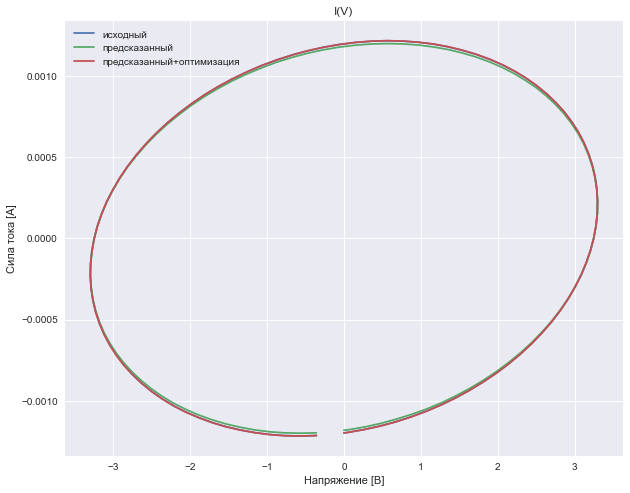

success: [16.65444801] -> 16.507708607193774 circuit D_R
SUCCESS:


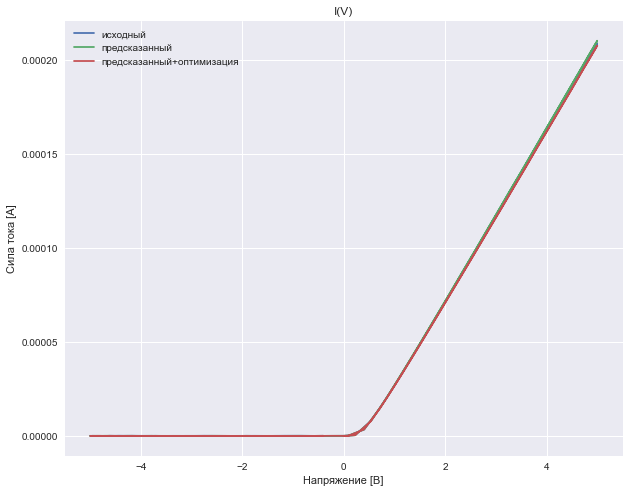

success: [39.96700109] -> 38.4368837520735 circuit DR
SUCCESS:


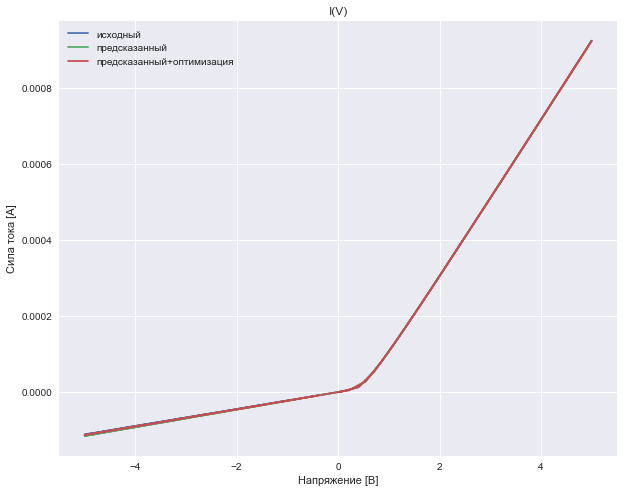

success: [16.74117297] -> 17.082510216617898 circuit R
SUCCESS:


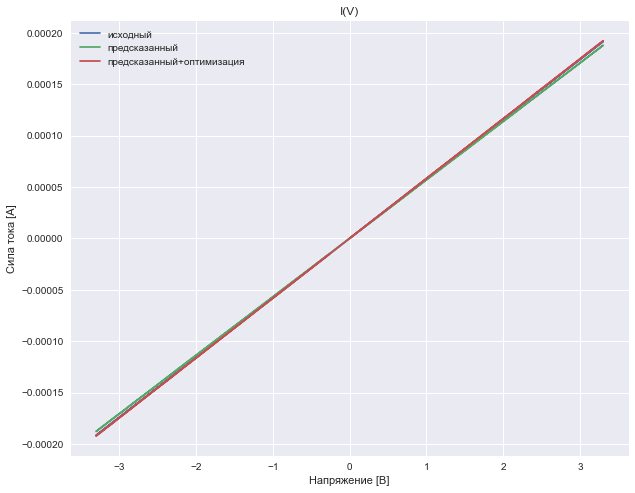

success: [65.02376923] -> 63.35691554951507 circuit D_R
SUCCESS:


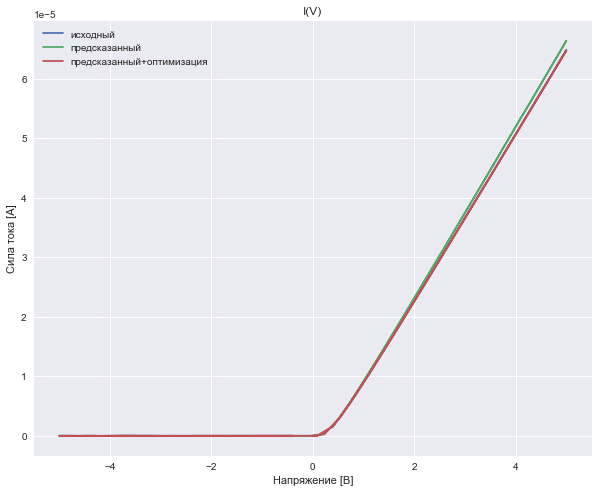

!!fail:  [77.30654144] -> [77.53132707  0.41073419] DR detected like DR_R
FAIL:


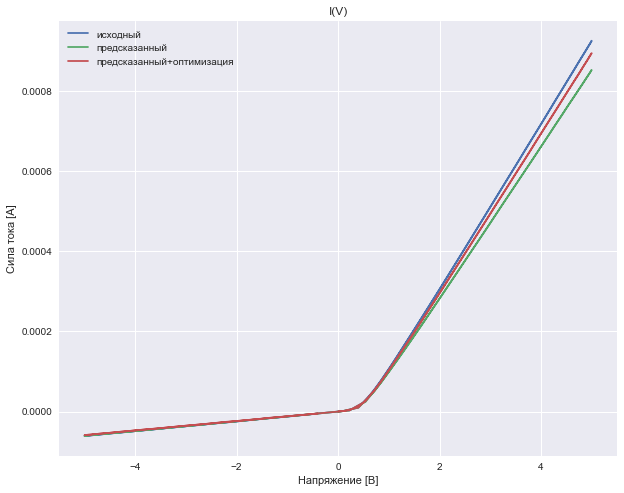

success: [42.21292363] -> 165.03362421704384 circuit L
SUCCESS:


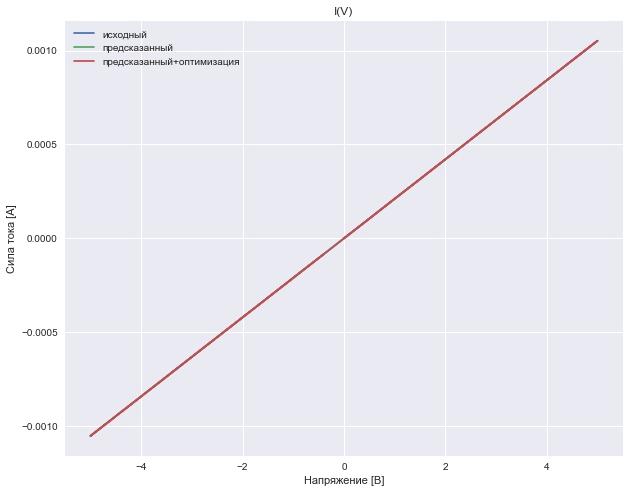

success: [85.86358677] -> 86.11284627928262 circuit DR
SUCCESS:


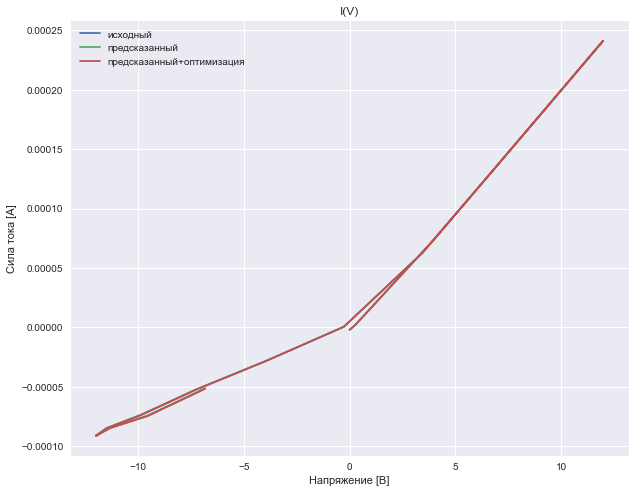

success: [78.5766039] -> 78.1224287706458 circuit R
SUCCESS:


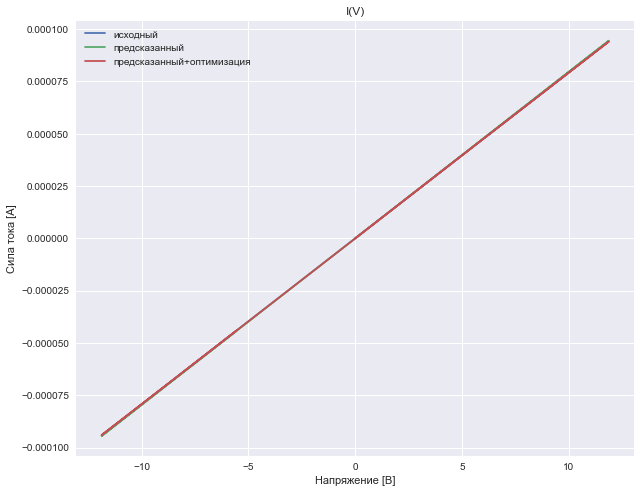

success: [69.22281958] -> 69.2111531971045 circuit R
SUCCESS:


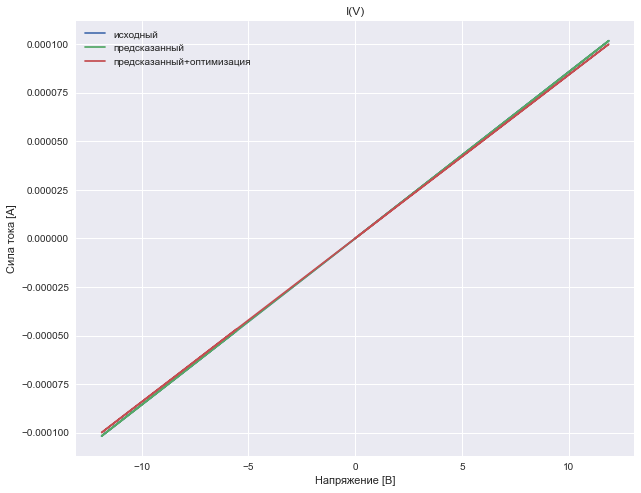

success: [79.39207465] -> 81.97089800686592 circuit D_R
SUCCESS:


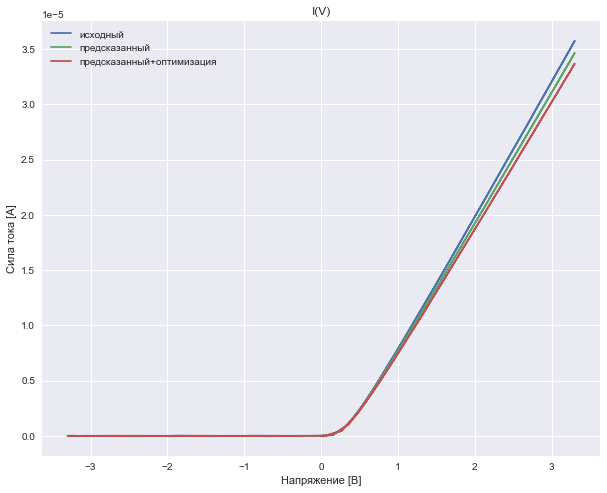

success: [67.57760114] -> 75.26636588050206 circuit C
!!fail:  [0.42951968] -> 0.6564168855347223 R detected like DR
FAIL:


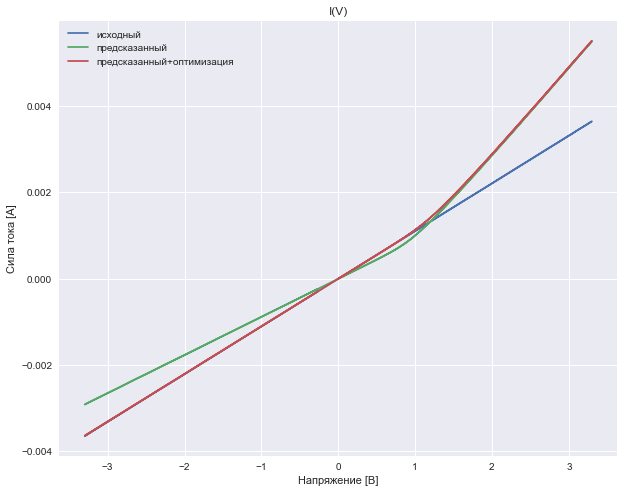

success: [70.00231474] -> 58.56619565356965 circuit C
success: [31.55328935] -> 32.011160469842366 circuit R
success: [7.30056214] -> 5.6764417018553885 circuit C
success: [17.97812929] -> 17.47347498868195 circuit C
success: [8.98834641] -> 8.719361180502517 circuit DR
success: [86.93489798] -> 87.57158428586735 circuit D_R
success: [95.50947416] -> 94.57753985397052 circuit DR
success: [50.37607248] -> 51.25126100404107 circuit D_R
success: [61.93373456] -> 61.00793257832834 circuit D_R
success: [37.58145319] -> 37.95822618449465 circuit DR
success: [85.45649968] -> 84.9895122954643 circuit D_R
success: [55.02262341] -> 53.34145029404927 circuit D_R
success: [33.42564429] -> 265.00122534563684 circuit L
success: [32.25254464] -> 33.9515231902095 circuit C
success: [98.17739969] -> 94.7757128766956 circuit DR
success: [49.37377168] -> 51.56821522350889 circuit C
success: [25.18569986] -> 25.152222273885954 circuit DR
success: [65.66996591] -> 232.10322953057783 circuit L
success: [59.

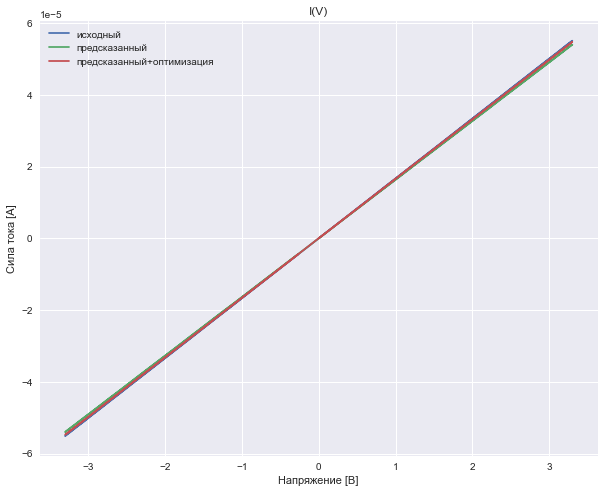

success: [24.34738618] -> 24.500475674993144 circuit DR

SUCCESS: 47, FAIL: 3 of 50 tests
RANK2 CIRCUIT TESTING ..
success: [15.73606028 65.57582641] -> [15.95326884 64.63610145] circuit DR_DR
SUCCESS:


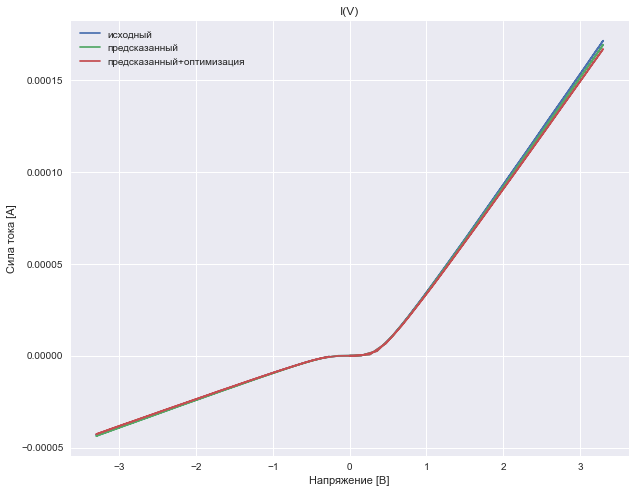

!!fail:  [48.91762096 97.19366623] -> 96.40786825868157 RC detected like C
FAIL:


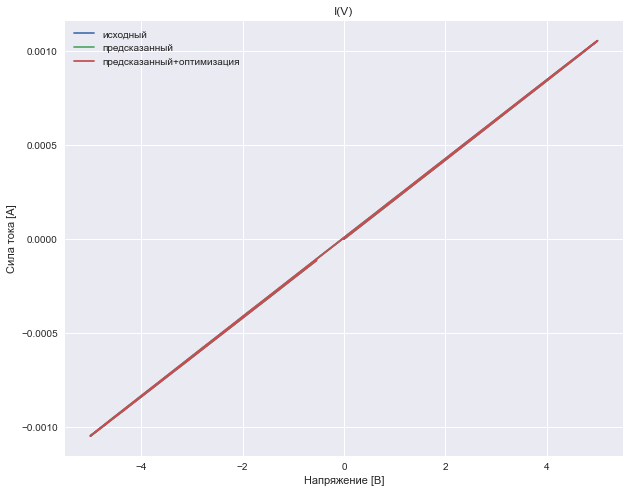

!!fail:  [60.14805439 24.4665582 ] -> 26.075817965443527 RC detected like C
FAIL:


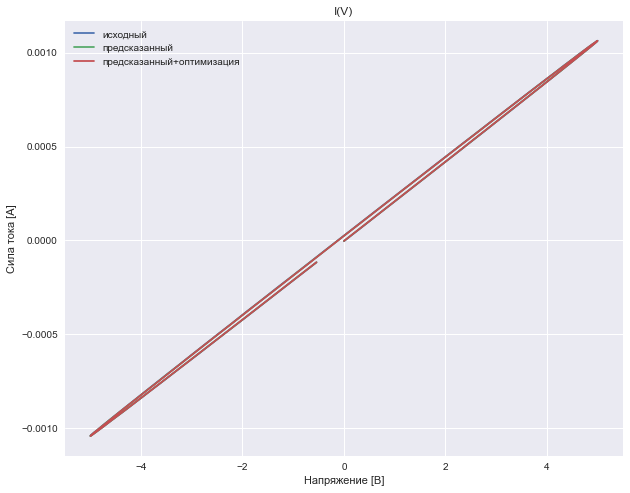

success: [89.37519525  1.73119019] -> [92.3860693  46.20617831] circuit R_C
SUCCESS:


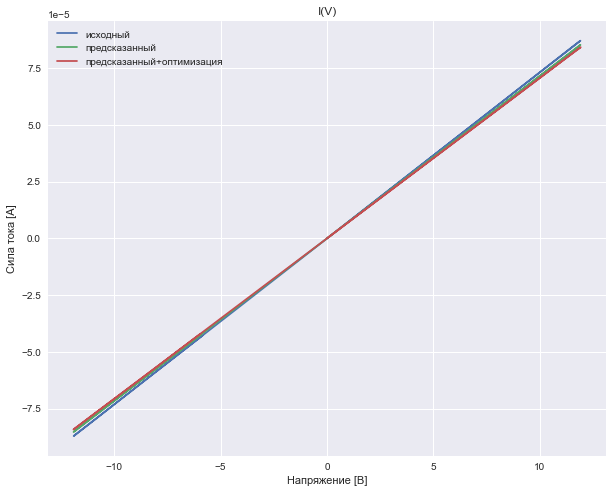

success: [11.04662032 42.76613058] -> [10.05373841 42.70364061] circuit DR_DR
SUCCESS:


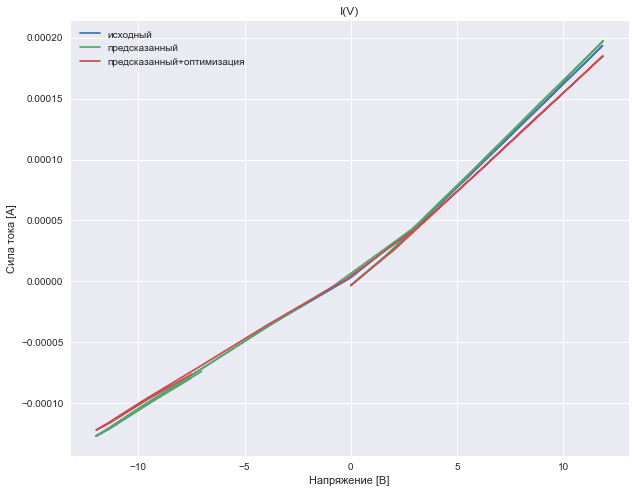

success: [79.93501045 64.00346742] -> [80.57642417 63.45871683] circuit DR_DR
SUCCESS:


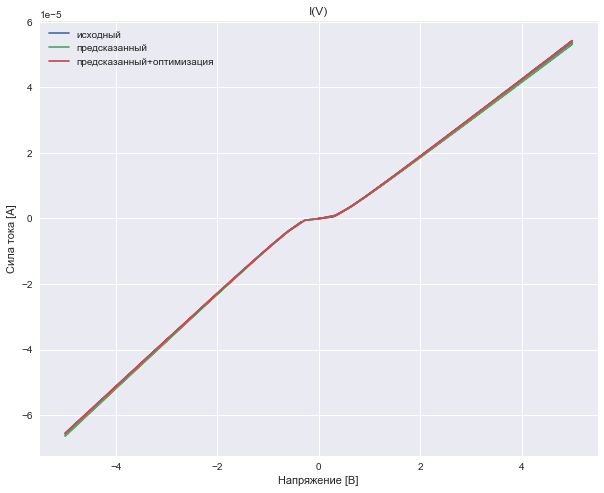

success: [23.34231877 85.43173829] -> [22.5024937  46.05975835] circuit R_C
SUCCESS:


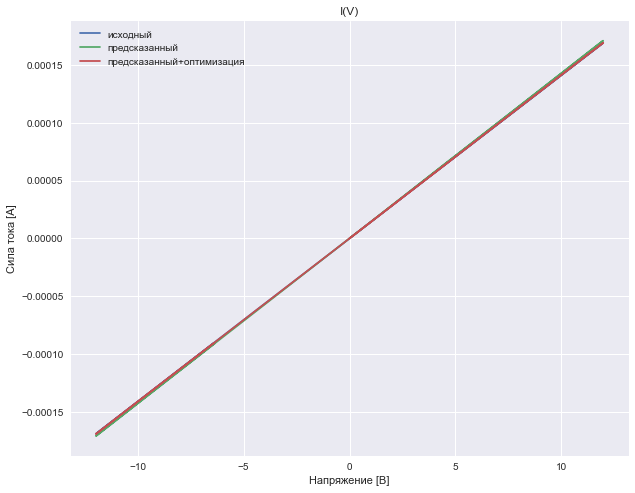

success: [56.15070593 55.2689973 ] -> [55.42544116 58.21931704] circuit R_C
SUCCESS:


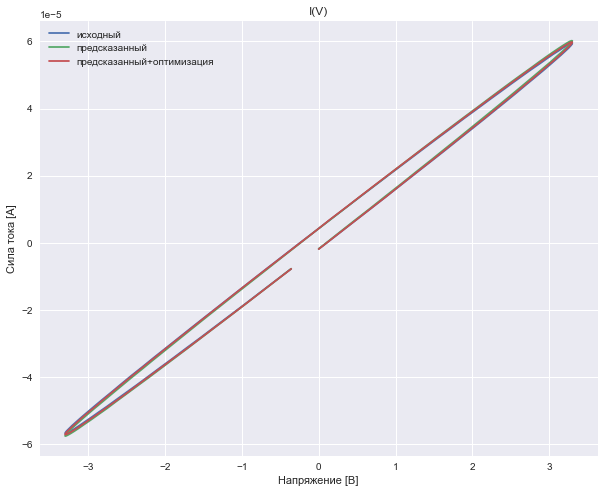

success: [34.84764537 64.4852609 ] -> [35.98268084 65.91514159] circuit DR_DR
SUCCESS:


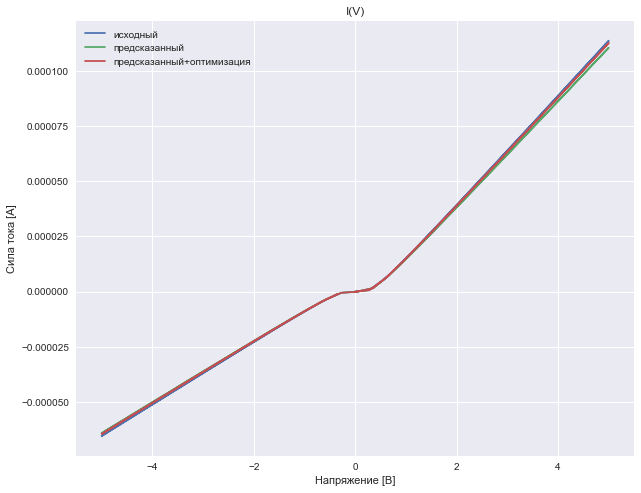

success: [40.13699069 11.32061492] -> [40.28639305 13.48993586] circuit R_C
SUCCESS:


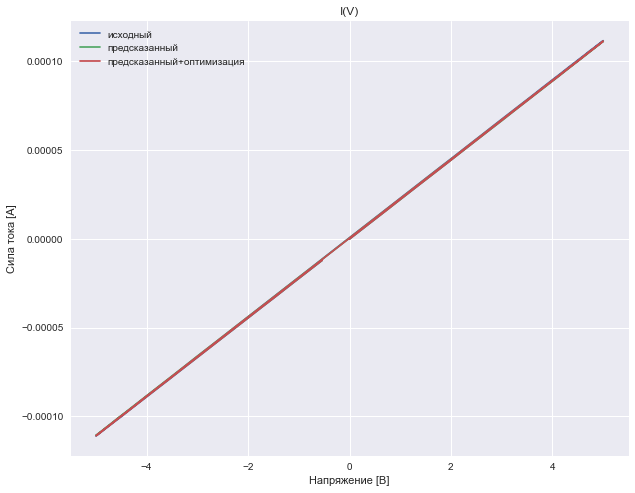

success: [46.36888142 61.33637242] -> [43.70715364 63.49069942] circuit DR_R
SUCCESS:


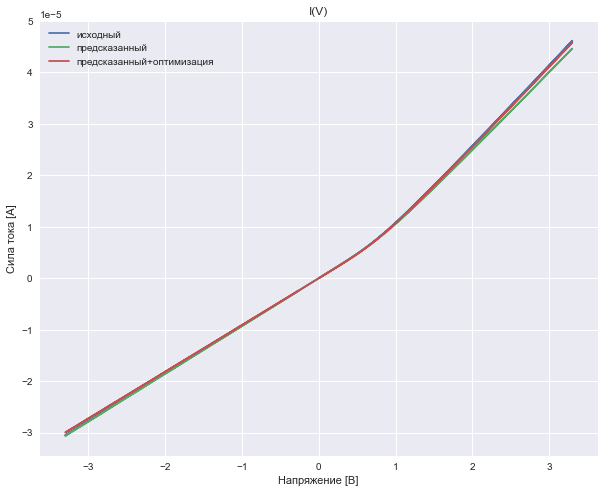

success: [31.33446203  9.53423952] -> [31.85113389  9.80781019] circuit DR_DR
SUCCESS:


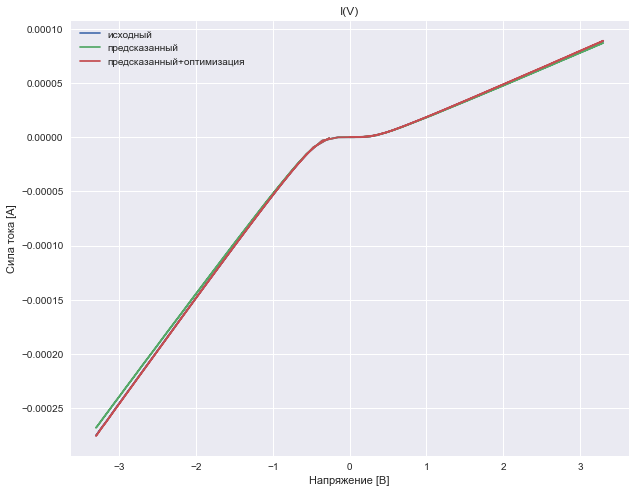

!!fail:  [64.66068358  1.75838476] -> 52.06542638144944 RC detected like C
FAIL:


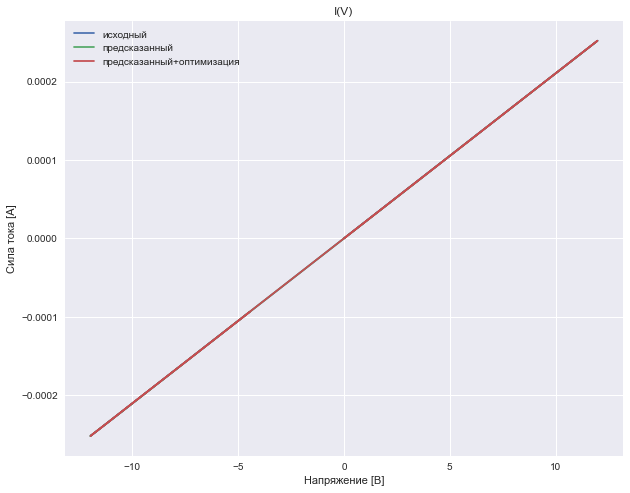

success: [88.31182022 62.05374459] -> [86.81923581 66.0640359 ] circuit R_C
success: [46.24829089 40.08017559] -> [48.24542327 40.39081479] circuit RC
success: [60.63891182 97.49361826] -> [61.33456078 94.2937818 ] circuit DR_R
success: [76.50310949 64.8169201 ] -> [76.65494657 48.45674161] circuit R_C
success: [20.7175992  69.17600486] -> [20.29579086 44.99035159] circuit R_C
success: [31.21564023 74.05602228] -> [31.83765081 75.32657643] circuit DR_R
success: [63.74298321 99.17070134] -> [60.97028977 98.03607822] circuit RC
success: [46.93402438 55.30602341] -> [40.99109151 55.97003862] circuit DR_R
!!fail:  [99.86658513  3.78068056] -> 51.13702844771967 RC detected like C
FAIL:


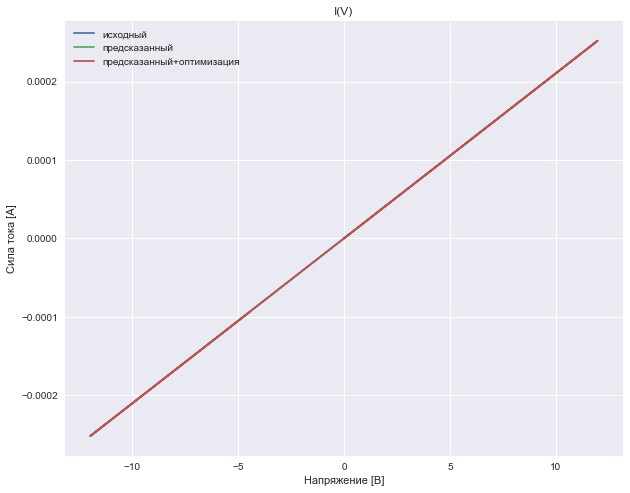

success: [13.6594862  49.99867432] -> [33.95483058 49.65254337] circuit RC
success: [99.73487859 77.01426038] -> [97.00722441 48.37698421] circuit R_C
success: [49.96365535 13.64758431] -> [51.29164806 55.06927459] circuit R_C
success: [38.8286583  93.69723079] -> [39.09707258 54.40473214] circuit R_C
!!fail:  [13.27440109 58.78416084] -> [63.85625506 12.85479552] DR_DR detected like DR_R
FAIL:


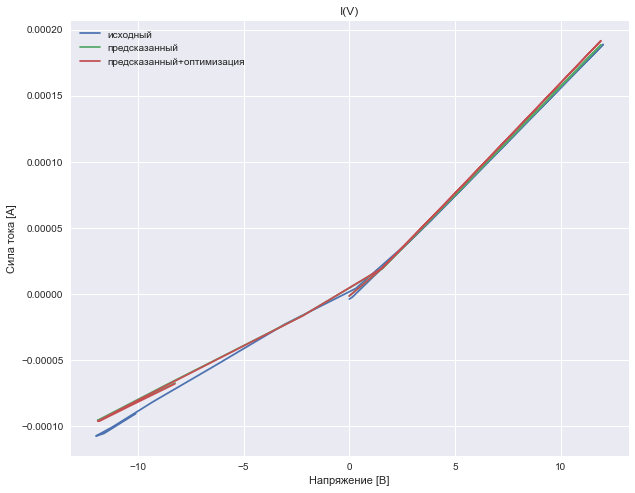

success: [44.895873   47.73206438] -> [45.65356042 47.58954014] circuit DR_DR
success: [29.96813516 12.39510755] -> [29.37663271 11.60177221] circuit DR_DR
success: [10.26610668 98.14490061] -> [ 9.60892819 79.02896126] circuit R_C
success: [41.25029542 35.32821662] -> [40.90092818 35.49771583] circuit DR_R
!!fail:  [46.56079133 10.64183615] -> [45.12176128 13.62050686 90.44730004] DR_DR detected like DR_DR_R
FAIL:


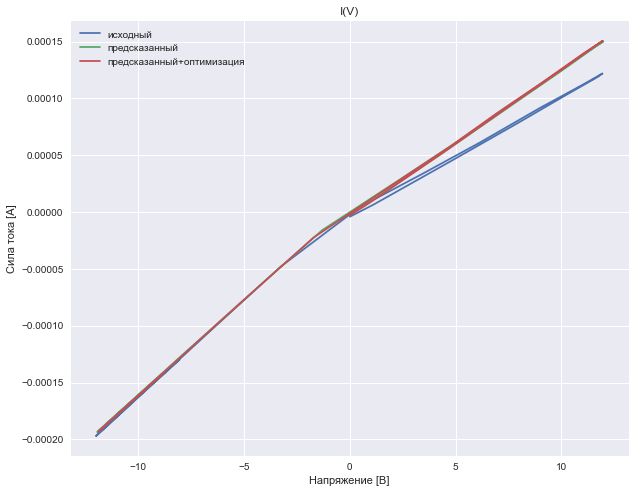

success: [ 1.71134355 88.37701029] -> [ 5.53085335 84.72617262] circuit DR_R
!!fail:  [ 8.74118074 42.44207361] -> [1.50751476 4.11357174] R_C detected like DR_R
FAIL:


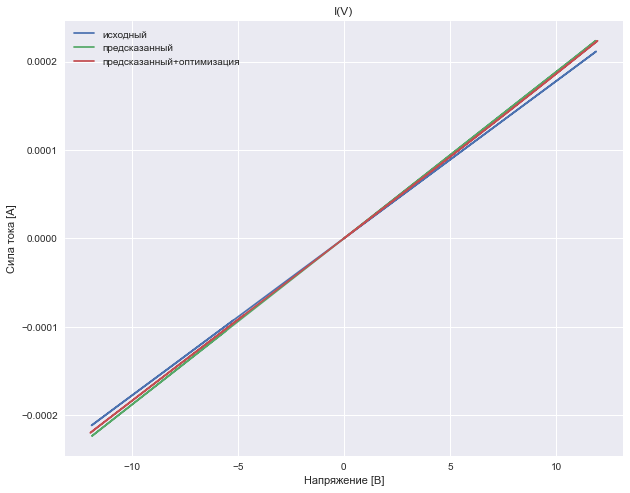

success: [19.73414951 22.80271625] -> [17.1475967  23.47897183] circuit DR_R
success: [55.75986004 51.86578465] -> [55.31765308 55.49808059] circuit R_C
success: [50.04412357 76.12522635] -> [51.48486679 77.44867157] circuit DR_R
success: [13.00029937 92.79001316] -> [14.67640083 94.17986354] circuit DR_R
success: [33.07149693 62.72583133] -> [34.10508099 71.14683745] circuit R_C
!!fail:  [40.27386402  5.30027068] -> 45.667531866847725 RC detected like C
FAIL:


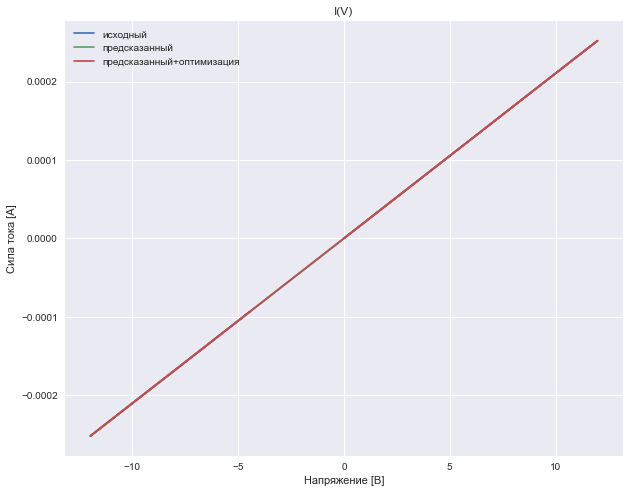

success: [68.84850187 37.02515239] -> [68.73085431 37.06665823] circuit RC
success: [ 4.82339346 75.83519495] -> [ 3.03466844 73.03959265] circuit RC
success: [88.43196739 29.4225728 ] -> [87.2069467  25.73115589] circuit R_C
success: [44.8227729 54.3460334] -> [41.58065327 55.59494281] circuit DR_R
success: [80.09945906 43.91148876] -> [80.49126335 43.86816512] circuit DR_DR
!!fail:  [84.62024987 58.80104926] -> 27.81928886895883 RC detected like L
FAIL:


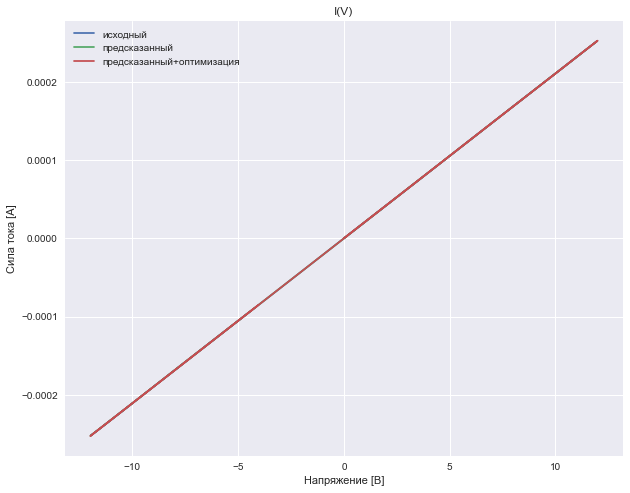

success: [82.86186392 66.51780679] -> [84.02228719 69.01847741] circuit R_C
success: [55.27843521 72.95802587] -> [55.21067528 51.62097941] circuit R_C
!!fail:  [65.09128287 45.44599069] -> 52.00871656079539 RC detected like C
FAIL:


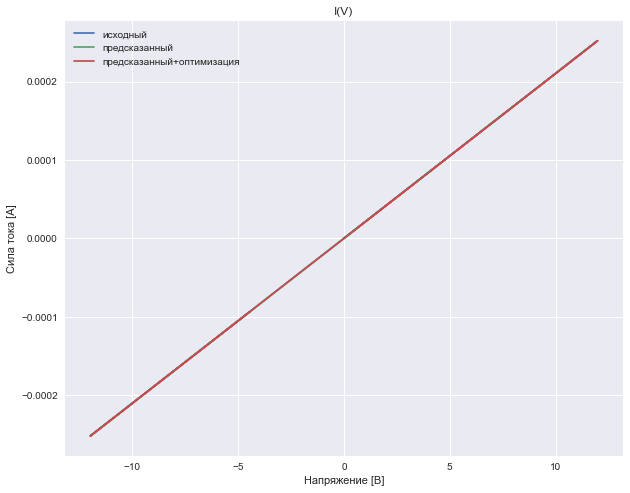

success: [19.34106023 78.48722738] -> [20.17343515 78.84788429] circuit RC

SUCCESS: 40, FAIL: 10 of 50 tests
RANK3 CIRCUIT TESTING ..
success: [ 7.56312626 73.54519606 48.27112945] -> [10.65047433 70.60516445 54.8829969 ] circuit DR_DR_R
SUCCESS:


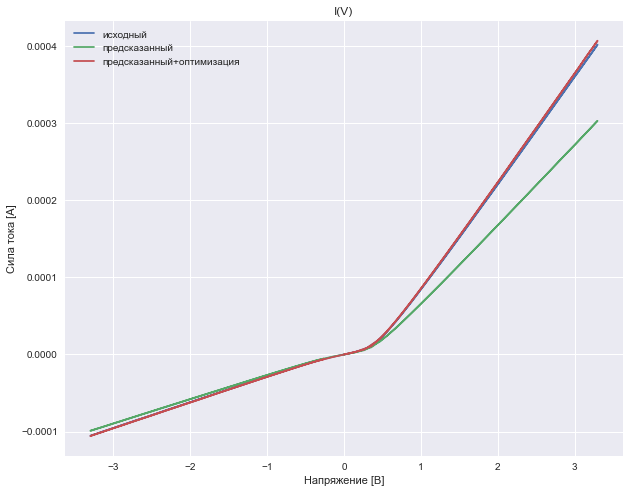

success: [55.80464111 93.16842518  7.85985753] -> [51.09810143 59.39819413  9.24332783] circuit DR_DR_R
SUCCESS:


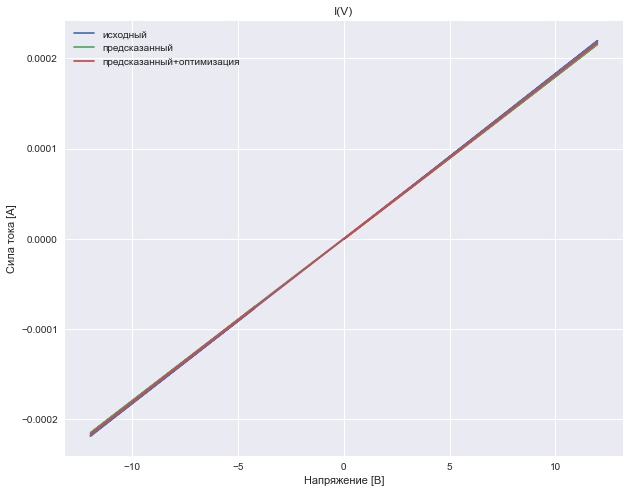

success: [41.05943241 64.39396178 96.63051849] -> [35.52459898 67.41443678 89.35926185] circuit DR_DR_R
SUCCESS:


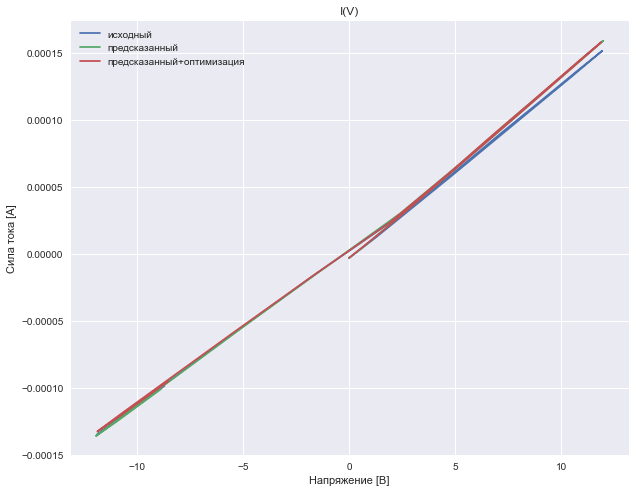

success: [80.07668321 92.95137733 49.04747944] -> [74.03691763 97.0123341  48.99902369] circuit DR_DR_R
SUCCESS:


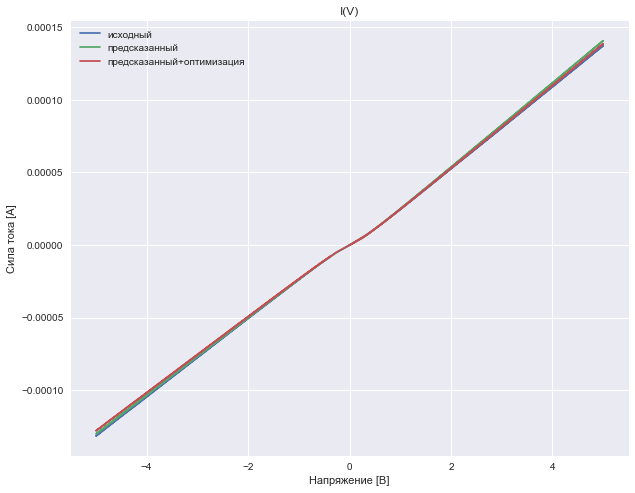

success: [82.31778484 84.71392122 86.49391718] -> [74.83864014 82.55558359 87.56363646] circuit DR_DR_R
SUCCESS:


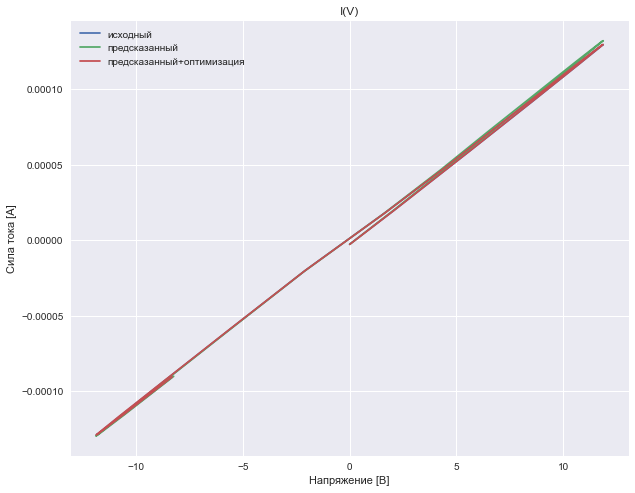

success: [79.46299193 93.48088194 46.3692686 ] -> [80.28241536 89.29163305 48.19556477] circuit DR_DR_R
SUCCESS:


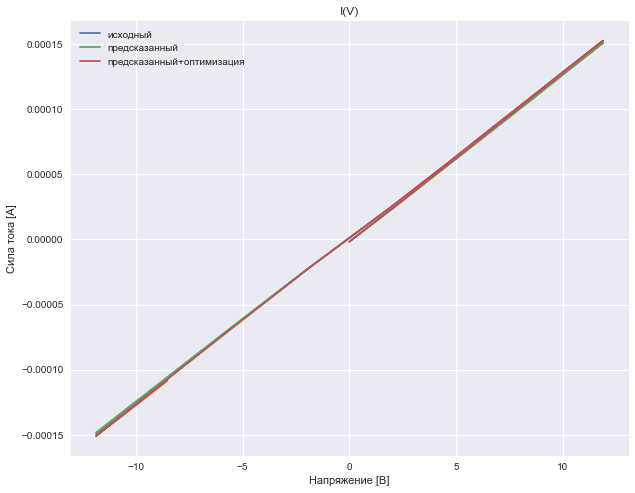

success: [53.32232409 74.79729227  5.55185395] -> [58.09392373 66.97500697  5.6562402 ] circuit DR_DR_R
SUCCESS:


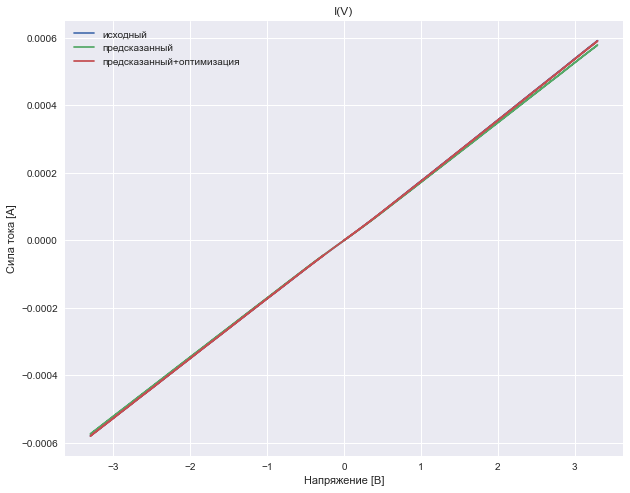

!!fail:  [97.6330038  68.27380955 12.63698222] -> 11.989847901087176 DR_DR_R detected like R
FAIL:


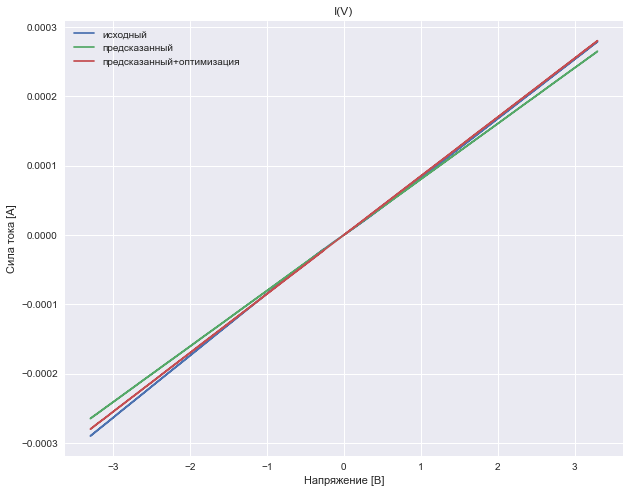

success: [92.83130281 27.74319437 62.53141458] -> [80.61361269 22.95864613 61.20270769] circuit DR_DR_R
SUCCESS:


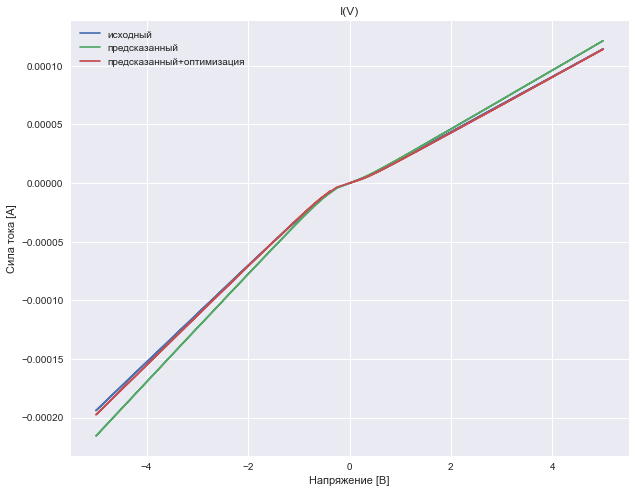

success: [87.77849703 56.43227273 92.45462953] -> [98.51581017 49.92812695 90.63635152] circuit DR_DR_R
SUCCESS:


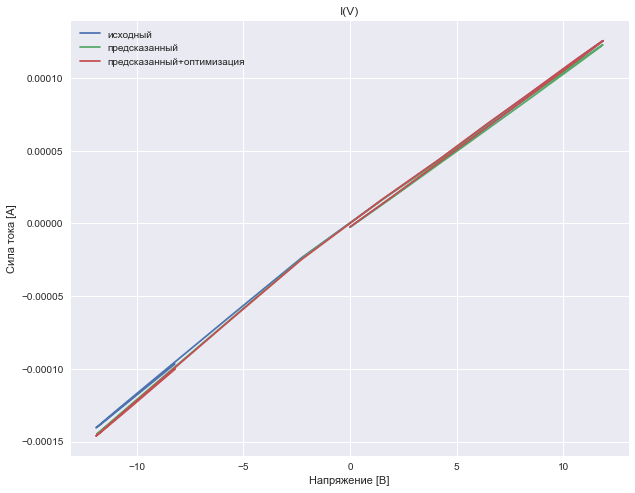

success: [76.18715104 87.71685336 60.8921187 ] -> [75.22112873 74.89587672 64.27778724] circuit DR_DR_R
SUCCESS:


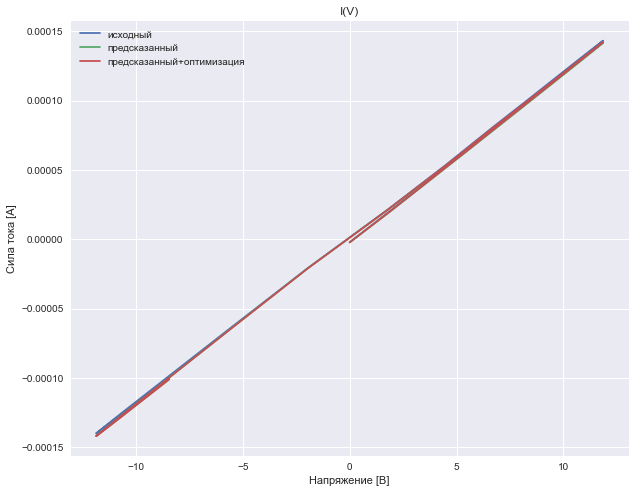

success: [88.4132335  16.29262739 15.03852844] -> [67.11237613 17.10155381 13.98064158] circuit DR_DR_R
!!fail:  [98.5368931  75.46399478  1.83586878] -> 1.6117189205814588 DR_DR_R detected like R
FAIL:


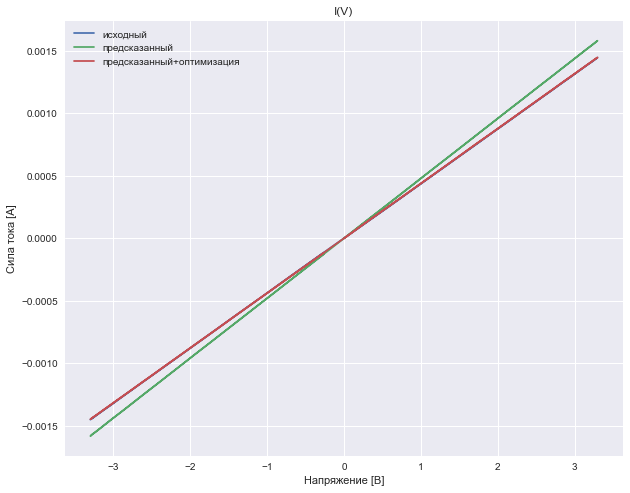

success: [66.25477445 97.33621991 91.20906998] -> [62.2467251  88.02567449 90.99287254] circuit DR_DR_R
!!fail:  [95.02549815 31.03936714  5.11561519] -> 4.656336603796137 DR_DR_R detected like R
FAIL:


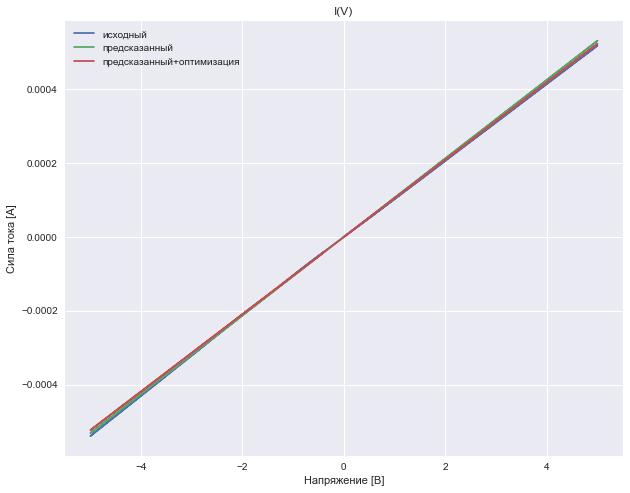

success: [94.86239334 20.57141501 58.59958994] -> [76.75230307 23.60429549 59.0583398 ] circuit DR_DR_R
success: [18.8250668  24.87498505 67.61223594] -> [16.70885562 23.34659892 64.86775941] circuit DR_DR_R
success: [10.34481255 40.77861072 31.00217631] -> [ 8.67681723 35.52969175 30.58549153] circuit DR_DR_R
success: [72.18900035 75.27738017 98.92335427] -> [58.14483488 81.56635768 88.6215514 ] circuit DR_DR_R
success: [93.450295   28.85713466 72.3393527 ] -> [87.5227431  31.45043052 73.58953586] circuit DR_DR_R
success: [94.77892254 71.62060414 48.18028402] -> [87.88424921 79.23599745 46.3781059 ] circuit DR_DR_R
success: [59.89350656 78.00482349 38.01852918] -> [54.40849266 83.75144851 35.8613915 ] circuit DR_DR_R
success: [33.36015639 39.8498899  49.22762065] -> [39.30269192 76.02599824 51.11355578] circuit DR_DR_R
success: [37.080224    2.87004982 13.28901211] -> [55.96658491  1.65997836 19.01507196] circuit DR_DR_R
!!fail:  [30.64985087 10.96875026 52.60960591] -> [17.69569291  

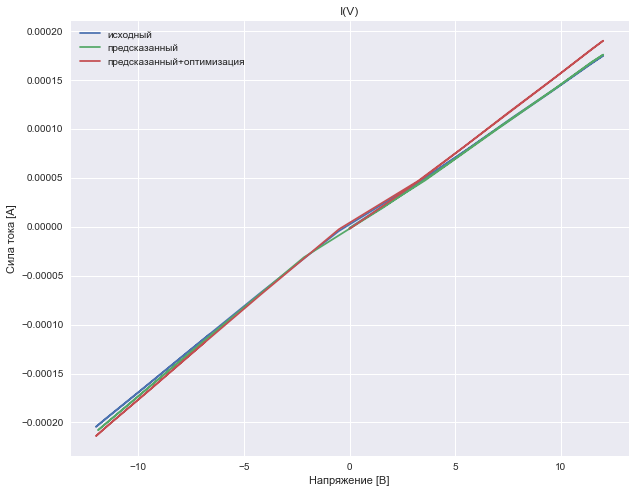

success: [ 7.13744592 90.88604088 82.51542326] -> [ 0.96828277 72.27098669 83.03078521] circuit DR_DR_R
success: [72.00477915 16.94625953 84.69305598] -> [62.91052147 23.85578728 82.39830539] circuit DR_DR_R
success: [85.00056039 13.84404665 35.44673543] -> [66.84550079 12.12530272 38.55550266] circuit DR_DR_R
success: [68.29619851 35.78307477 16.05882766] -> [71.26299041 36.68117123 15.47981392] circuit DR_DR_R
success: [ 1.26554182 27.98136207 44.96815896] -> [ 0.47662779 39.2767067  52.18245014] circuit DR_DR_R
success: [60.41666605 79.53870443 66.40542951] -> [59.43442664 75.88874513 68.72501268] circuit DR_DR_R
!!fail:  [20.83014769 20.17421814 71.78429184] -> [11.90991558 16.05305421] DR_DR_R detected like DR_R
FAIL:


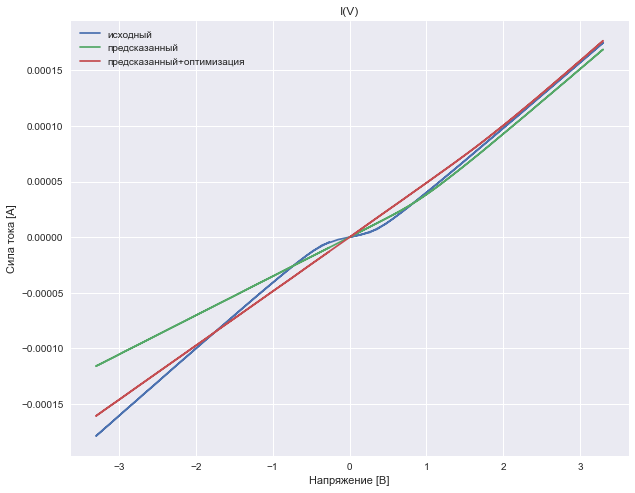

success: [95.84499176 57.50284173 89.16315358] -> [81.96956536 44.22421252 91.75072952] circuit DR_DR_R
success: [60.72597876 16.86802094 66.97281191] -> [70.27274528 16.63083825 72.79878947] circuit DR_DR_R
success: [30.4658542   7.08412331 87.45638194] -> [61.01483316  8.83178742 86.89664201] circuit DR_DR_R
success: [35.93833353 87.76358755 76.5315638 ] -> [29.19571315 83.66091635 76.5528289 ] circuit DR_DR_R
!!fail:  [16.37469804 12.25214771 28.84093488] -> [5.92249959 6.04296516] DR_DR_R detected like DR_DR
FAIL:


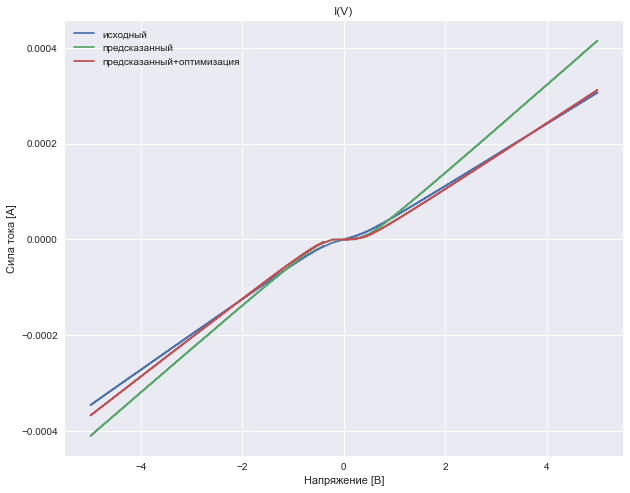

!!fail:  [73.67215488 32.63633681  3.74503397] -> 2.6419071297076835 DR_DR_R detected like R
FAIL:


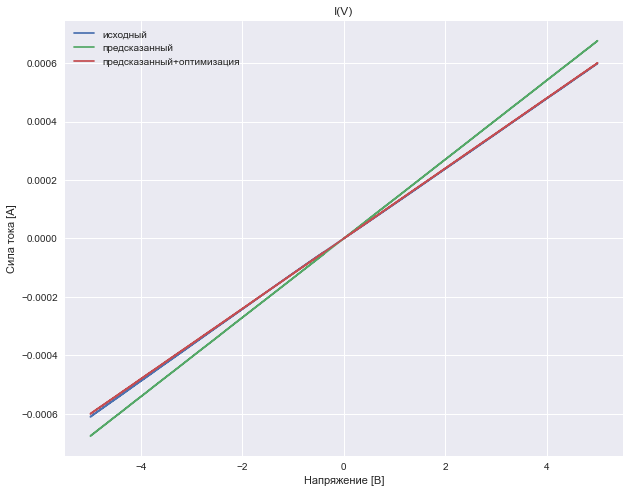

success: [98.55753481 96.8584552  20.22766849] -> [82.48079548 73.72522159 22.60251153] circuit DR_DR_R
!!fail:  [ 1.15577041 34.8844208  97.20063055] -> [ 1.29770827 24.36535502] DR_DR_R detected like DR_DR
FAIL:


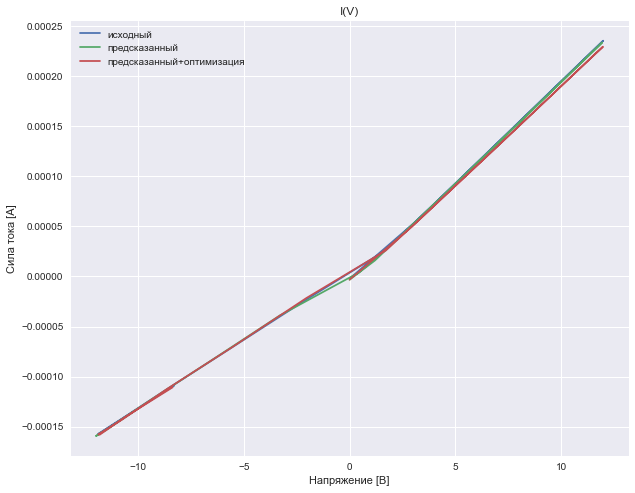

success: [78.47933977 25.21067958 10.99714445] -> [72.12419198 23.86325782 11.97710235] circuit DR_DR_R
success: [47.35194488 38.30780252 43.63678605] -> [66.44627886 44.55475746 43.29971409] circuit DR_DR_R
success: [64.81672283 44.57301392 88.41837019] -> [69.22029723 36.70040707 95.02240021] circuit DR_DR_R
success: [69.01662923 92.88778141 29.58251145] -> [66.30800201 75.27371032 31.15744749] circuit DR_DR_R
success: [85.63142431 27.90446717  3.56814292] -> [78.31566077 35.02425076  2.52336178] circuit DR_DR_R
success: [89.60021941 60.30096566 10.71244355] -> [79.64815909 63.9552093  10.6066532 ] circuit DR_DR_R
success: [37.87924381 82.4806815   7.71407852] -> [49.38734252 55.53776523  8.53013172] circuit DR_DR_R
success: [25.90164411 67.03514292 21.78980139] -> [28.18080749 72.49805146 18.19613864] circuit DR_DR_R
success: [69.34719448 14.82589948 36.24063362] -> [79.34818586 14.87324192 42.60393846] circuit DR_DR_R
success: [14.22143783 10.87352288 17.76165512] -> [33.26440673 1

In [19]:
#%%script false
cre.test_me()

### Тесты на реальных приборных Данных

**file E:\EyePoint\RealSignalFolder\100hz.json
F=100 V=5.0 lendata=100 Rcs=4750.0 cycle=3 SNR=70.0


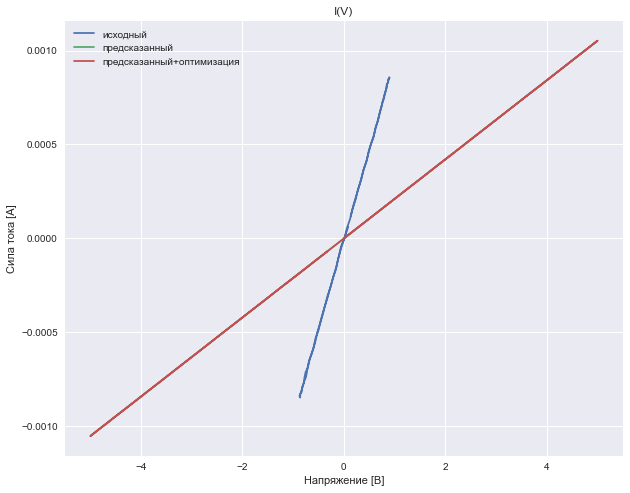

F=100 V=5.0 lendata=100 Rcs=4750.0 cycle=3 SNR=70.0


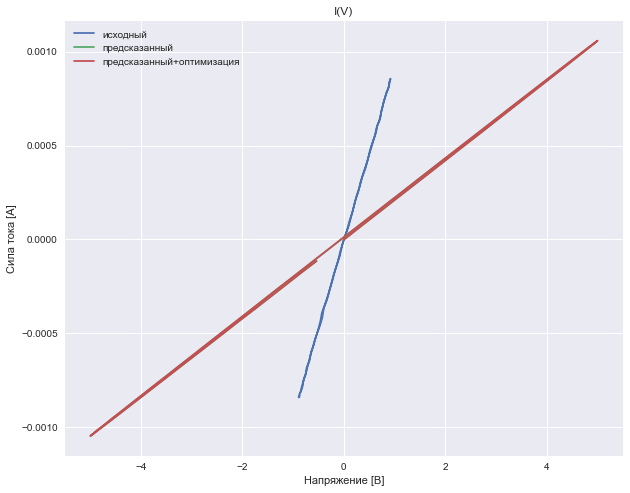

F=100 V=5.0 lendata=100 Rcs=4750.0 cycle=3 SNR=70.0


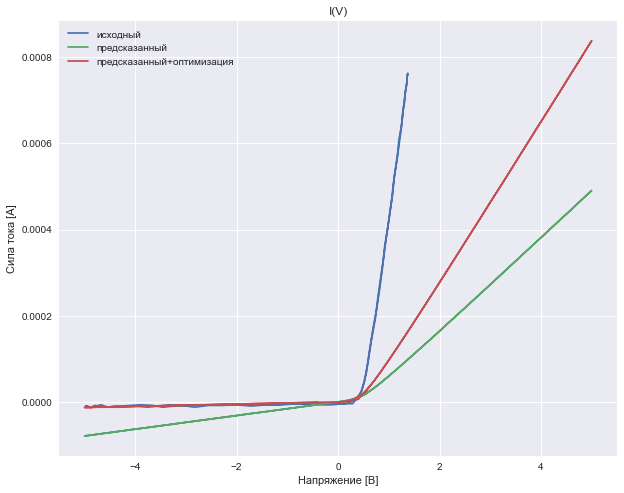

F=100 V=5.0 lendata=100 Rcs=4750.0 cycle=3 SNR=70.0


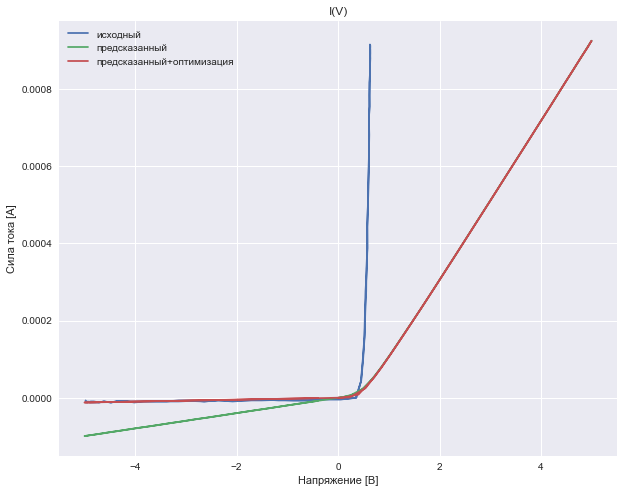

F=100 V=5.0 lendata=100 Rcs=4750.0 cycle=3 SNR=70.0


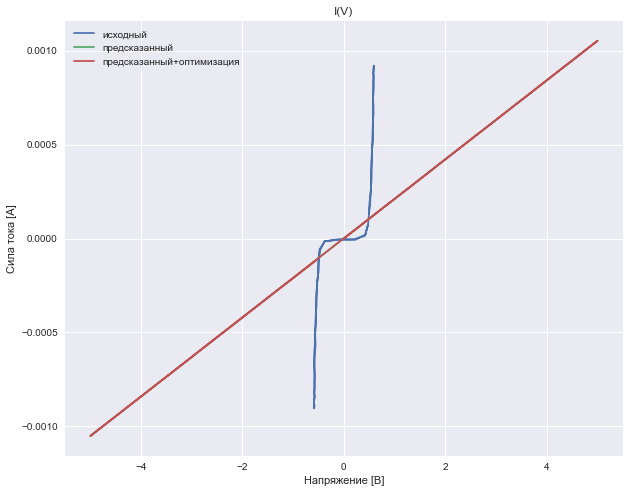

F=100 V=5.0 lendata=100 Rcs=4750.0 cycle=3 SNR=70.0


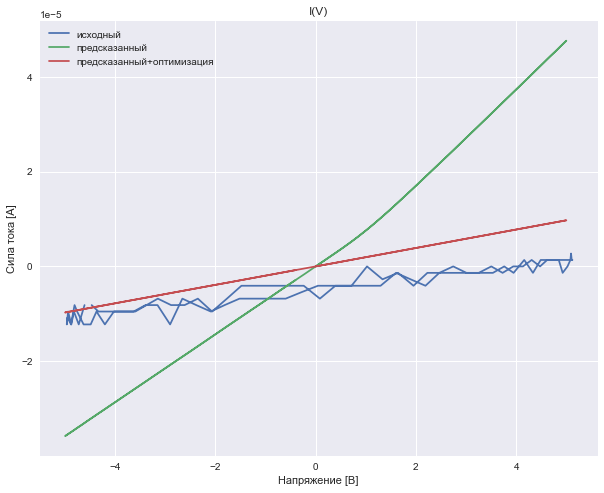

F=100 V=5.0 lendata=100 Rcs=4750.0 cycle=3 SNR=70.0


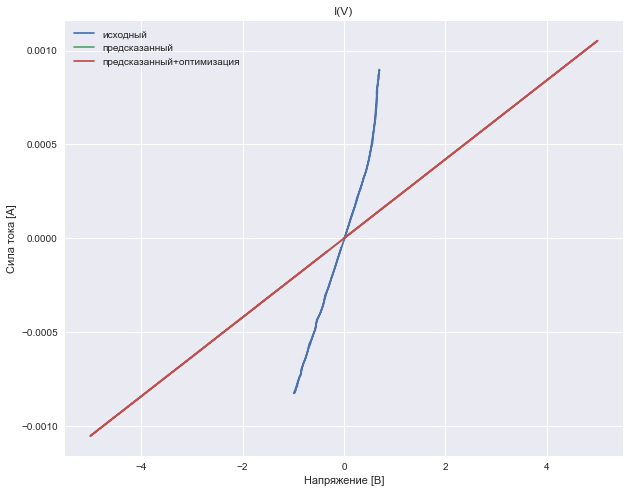

F=100 V=5.0 lendata=100 Rcs=4750.0 cycle=3 SNR=70.0


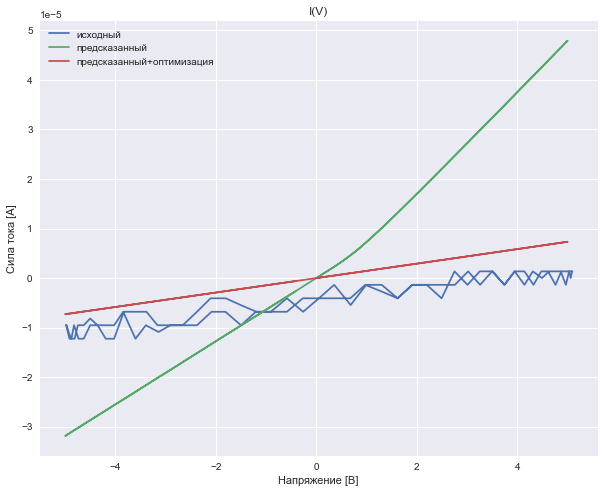

F=100 V=5.0 lendata=100 Rcs=4750.0 cycle=3 SNR=70.0


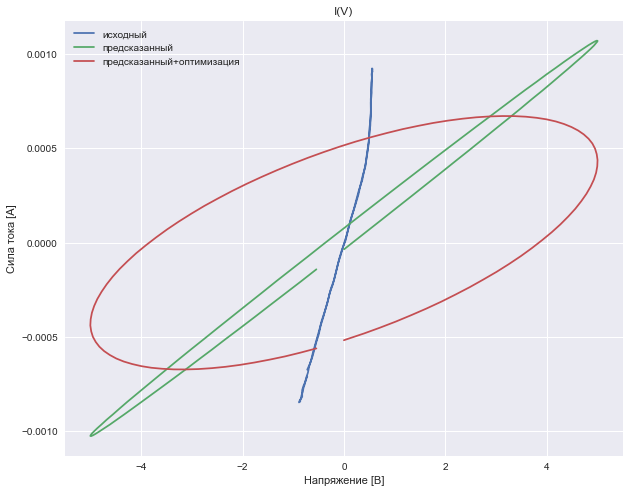

F=100 V=5.0 lendata=100 Rcs=4750.0 cycle=3 SNR=70.0


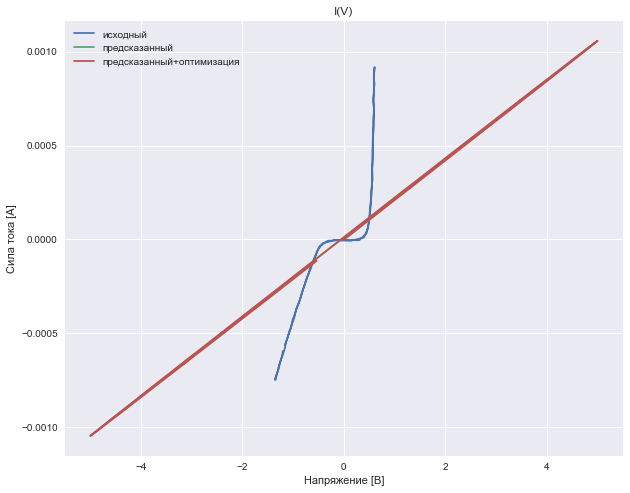

**file E:\EyePoint\RealSignalFolder\1hz_2020.json
F=1 V=3.299999952316284 lendata=100 Rcs=475.0 cycle=3 SNR=70.0


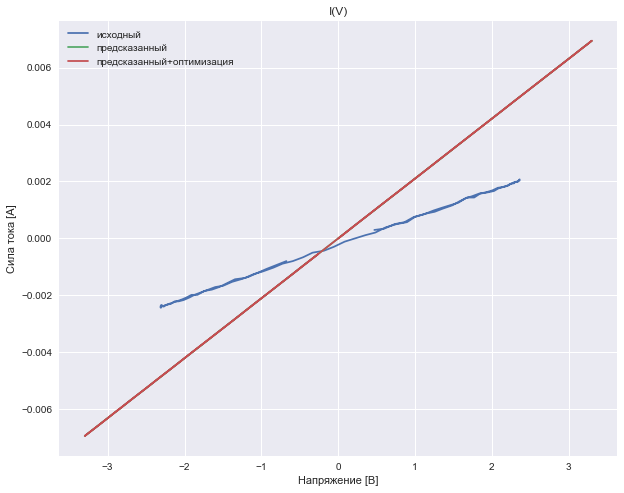

F=1 V=3.299999952316284 lendata=100 Rcs=475.0 cycle=3 SNR=70.0


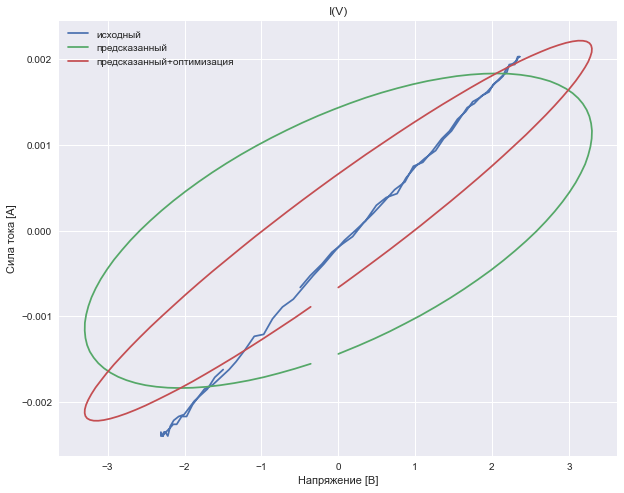

F=1 V=3.299999952316284 lendata=100 Rcs=475.0 cycle=3 SNR=70.0


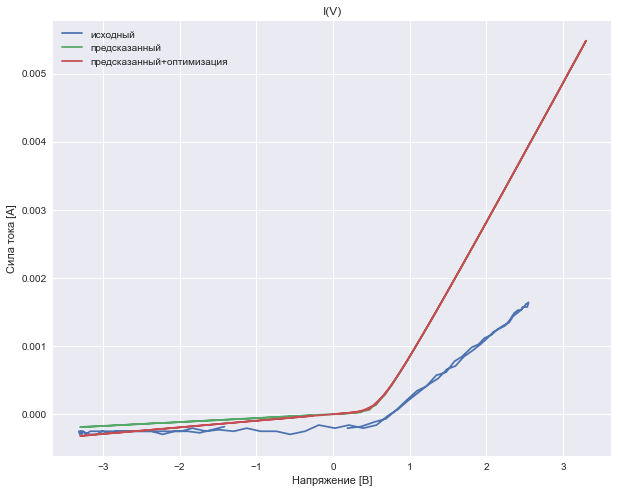

F=1 V=3.299999952316284 lendata=100 Rcs=475.0 cycle=3 SNR=70.0


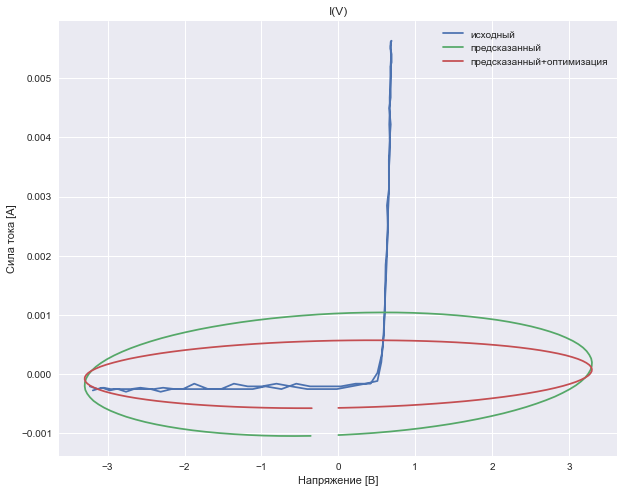

F=1 V=3.299999952316284 lendata=100 Rcs=475.0 cycle=3 SNR=70.0


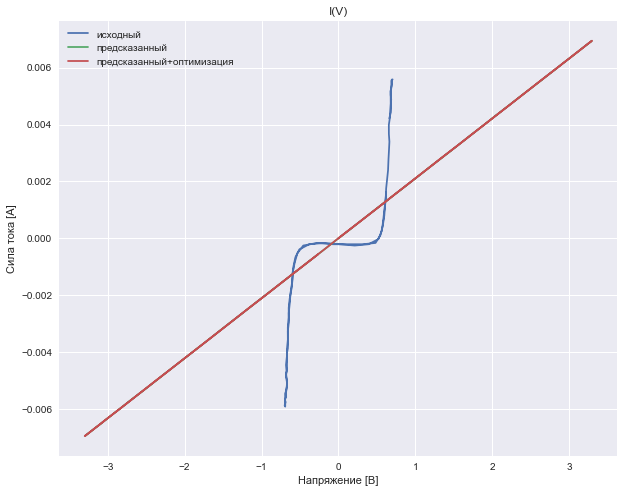

F=1 V=3.299999952316284 lendata=100 Rcs=475.0 cycle=3 SNR=70.0


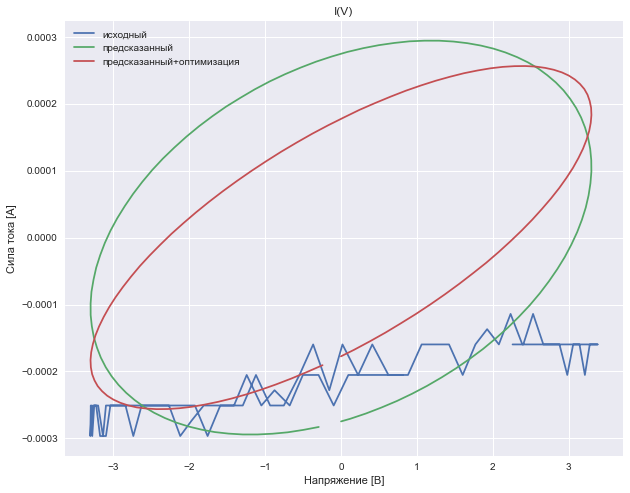

F=1 V=3.299999952316284 lendata=100 Rcs=475.0 cycle=3 SNR=70.0


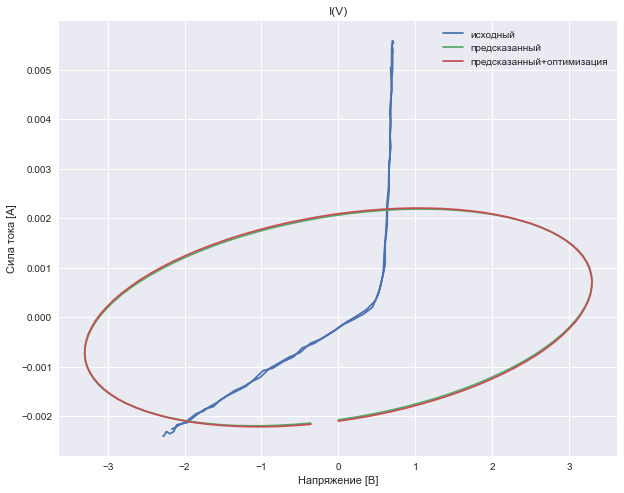

F=1 V=3.299999952316284 lendata=100 Rcs=475.0 cycle=3 SNR=70.0


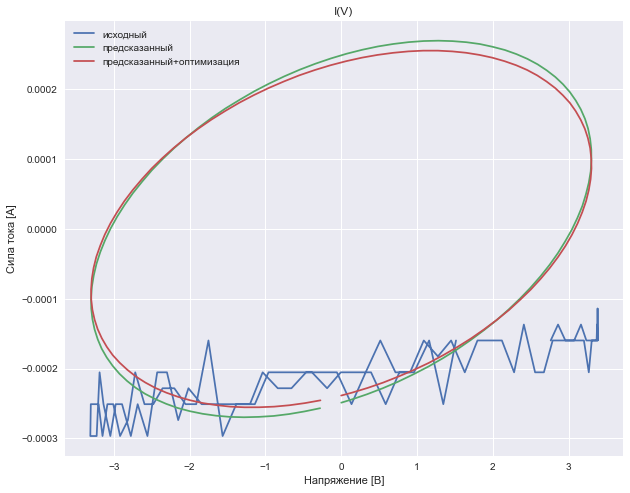

F=1 V=3.299999952316284 lendata=100 Rcs=475.0 cycle=3 SNR=70.0


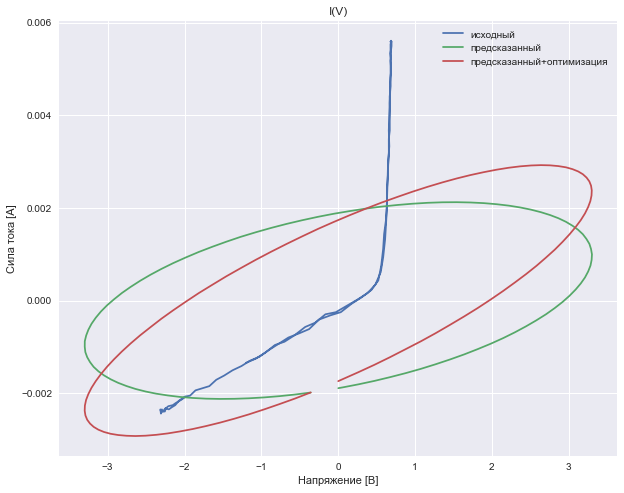

F=1 V=3.299999952316284 lendata=100 Rcs=475.0 cycle=3 SNR=70.0


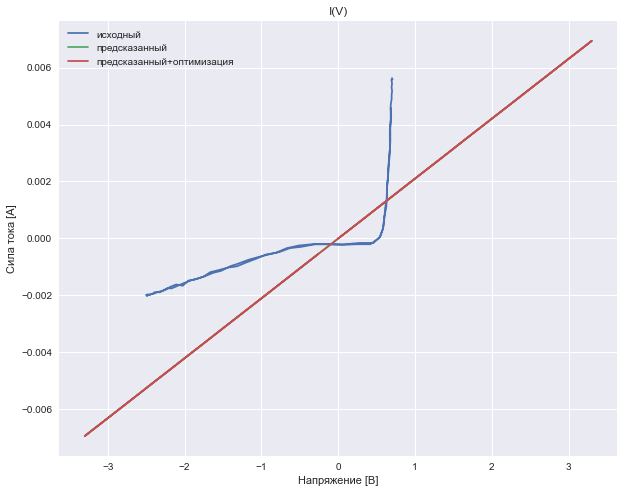

**file E:\EyePoint\RealSignalFolder\100hz_2020.json
F=100 V=5.0 lendata=100 Rcs=4750.0 cycle=3 SNR=70.0


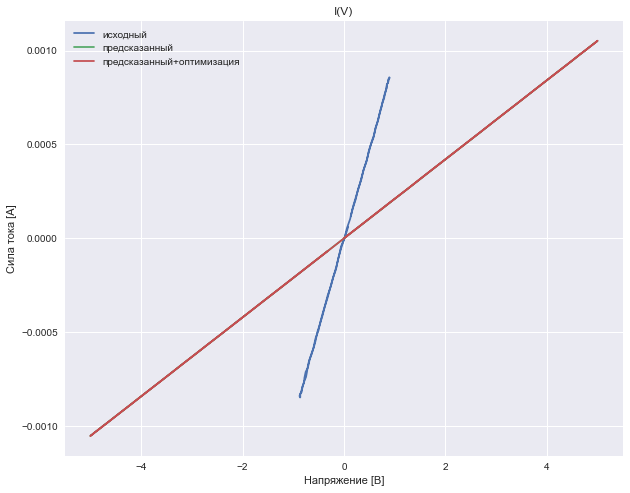

F=100 V=5.0 lendata=100 Rcs=4750.0 cycle=3 SNR=70.0


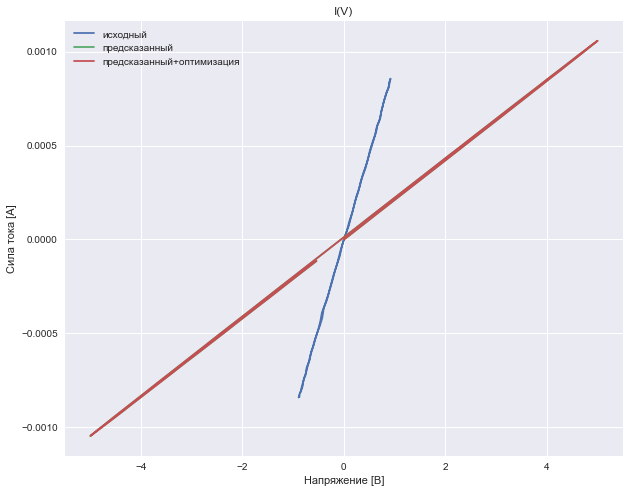

F=100 V=5.0 lendata=100 Rcs=4750.0 cycle=3 SNR=70.0


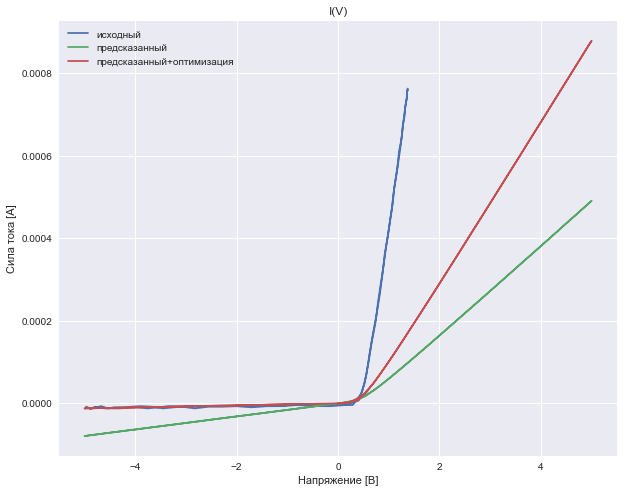

F=100 V=5.0 lendata=100 Rcs=4750.0 cycle=3 SNR=70.0


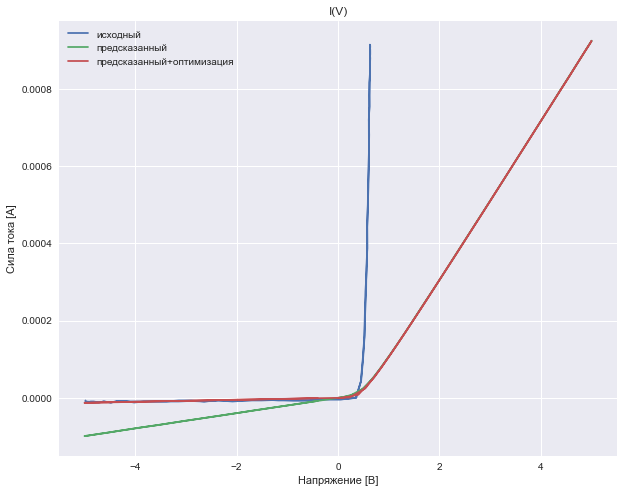

F=100 V=5.0 lendata=100 Rcs=4750.0 cycle=3 SNR=70.0


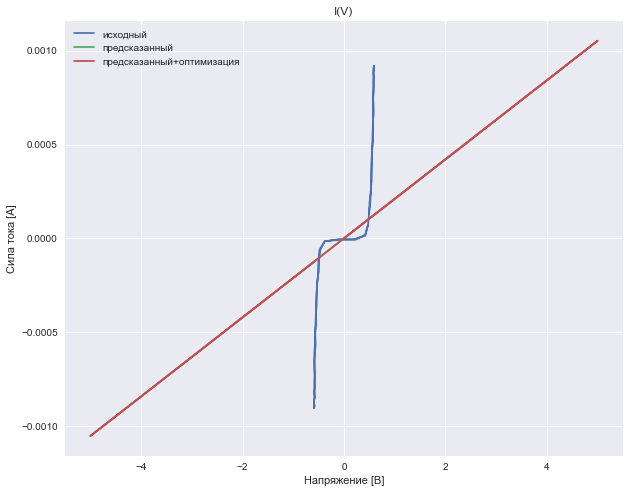

F=100 V=5.0 lendata=100 Rcs=4750.0 cycle=3 SNR=70.0


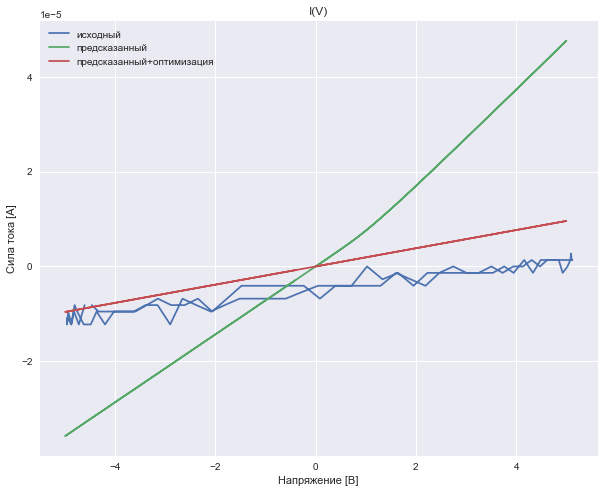

F=100 V=5.0 lendata=100 Rcs=4750.0 cycle=3 SNR=70.0


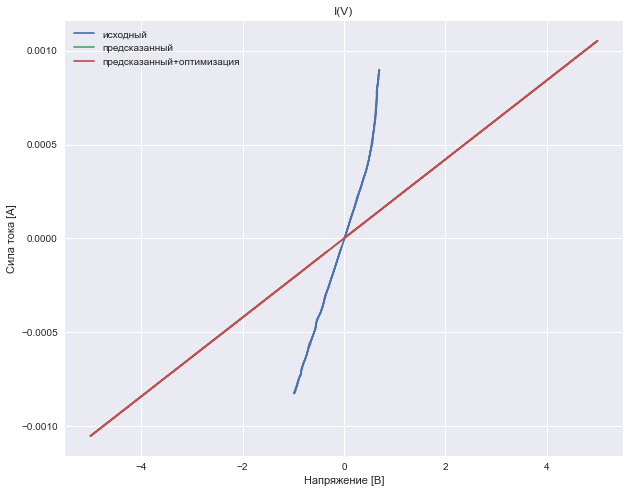

F=100 V=5.0 lendata=100 Rcs=4750.0 cycle=3 SNR=70.0


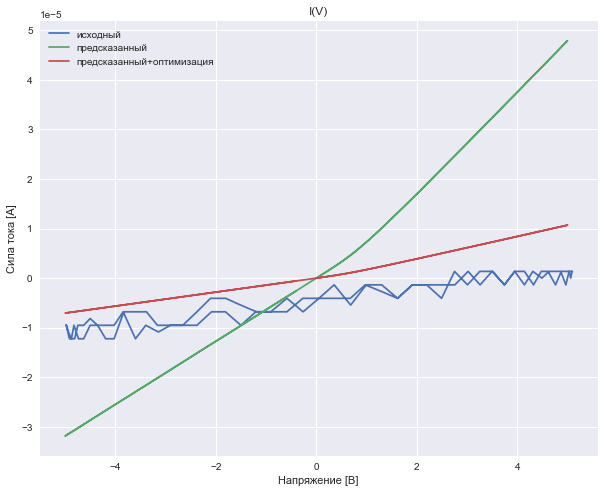

F=100 V=5.0 lendata=100 Rcs=4750.0 cycle=3 SNR=70.0


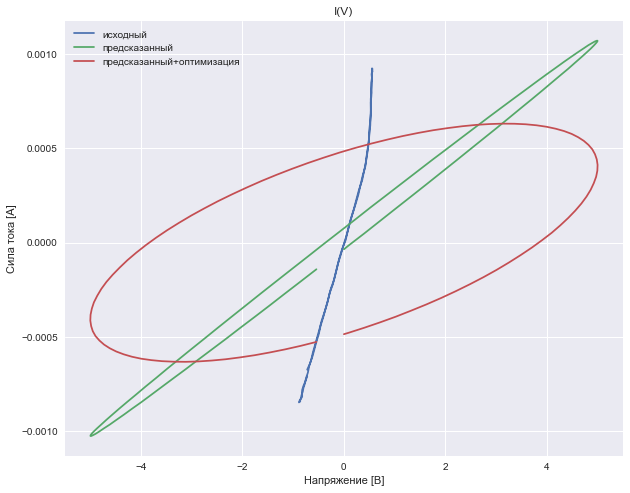

F=100 V=5.0 lendata=100 Rcs=4750.0 cycle=3 SNR=70.0


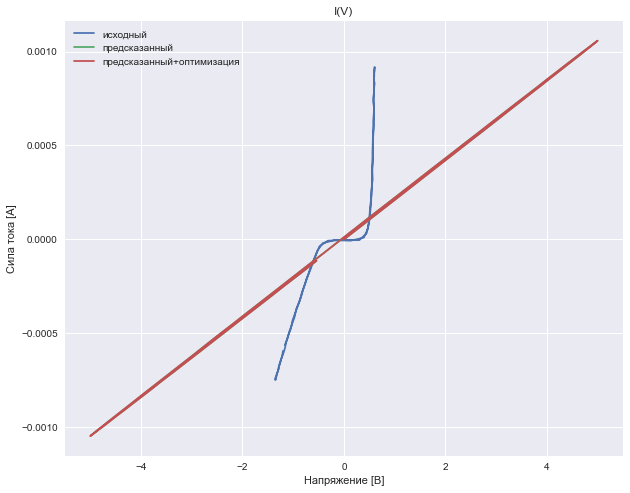

**file E:\EyePoint\RealSignalFolder\100khz_2020.json
F=100000 V=12.0 lendata=20 Rcs=47500.0 cycle=3 SNR=70.0


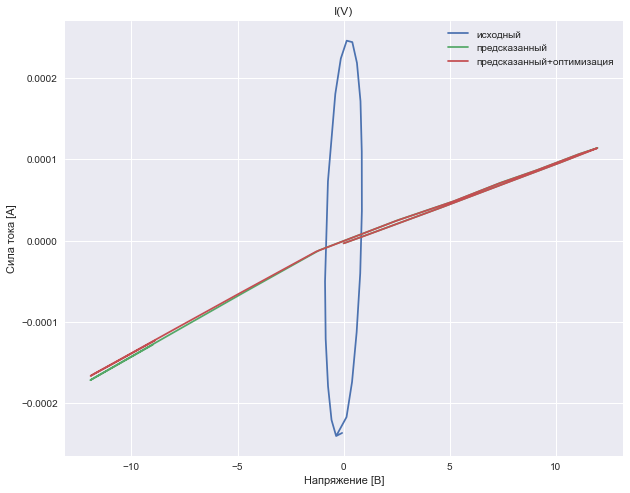

F=100000 V=12.0 lendata=20 Rcs=47500.0 cycle=3 SNR=70.0


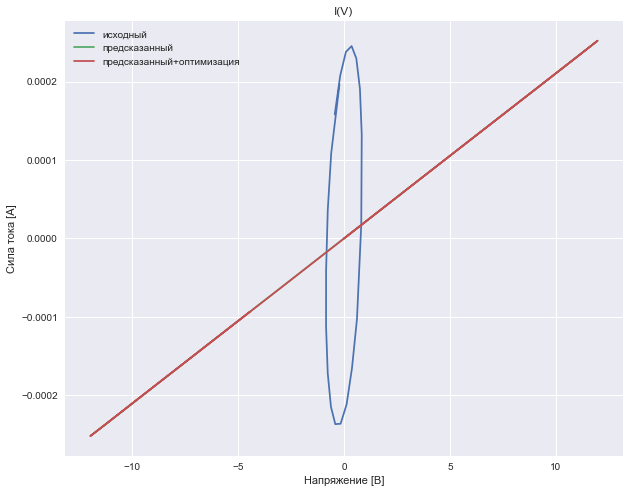

F=100000 V=12.0 lendata=20 Rcs=47500.0 cycle=3 SNR=70.0


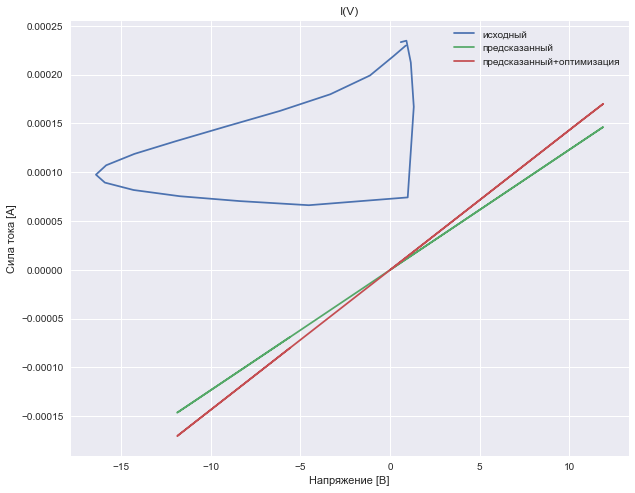

F=100000 V=12.0 lendata=20 Rcs=47500.0 cycle=3 SNR=70.0


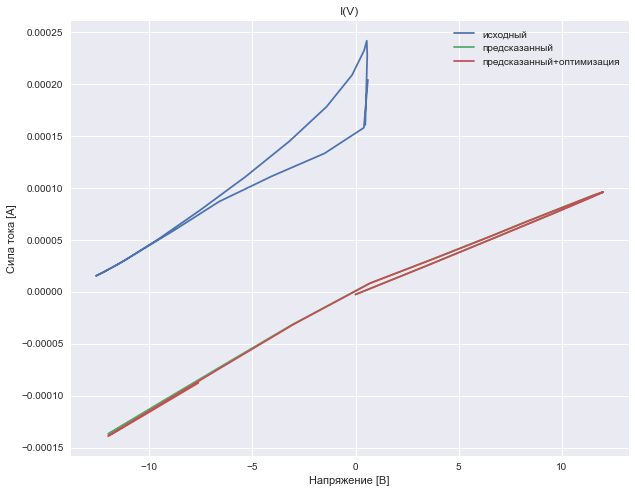

F=100000 V=12.0 lendata=20 Rcs=47500.0 cycle=3 SNR=70.0


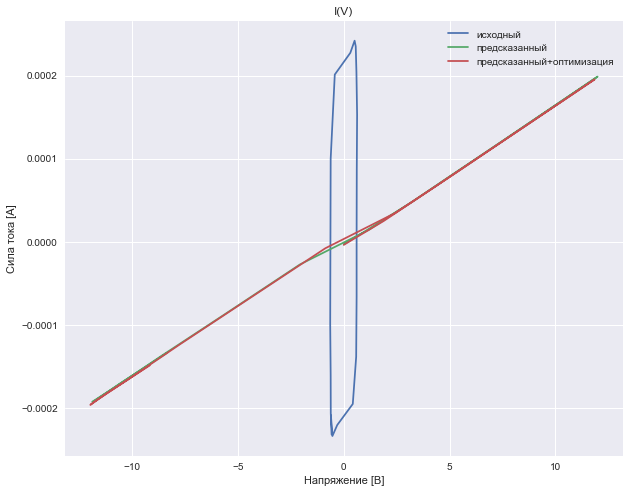

F=100000 V=12.0 lendata=20 Rcs=47500.0 cycle=3 SNR=70.0


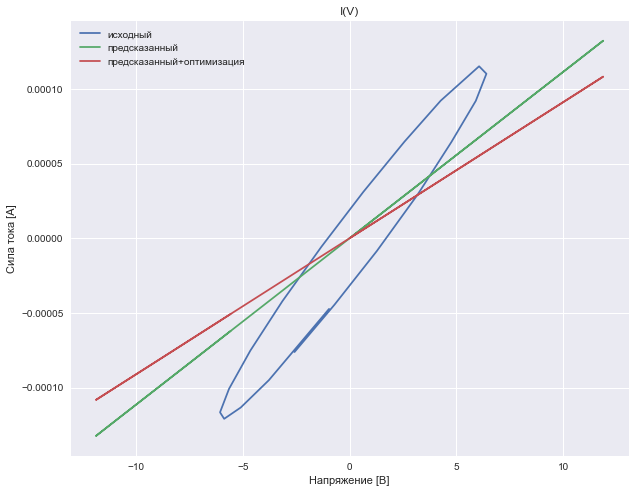

F=100000 V=12.0 lendata=20 Rcs=47500.0 cycle=3 SNR=70.0


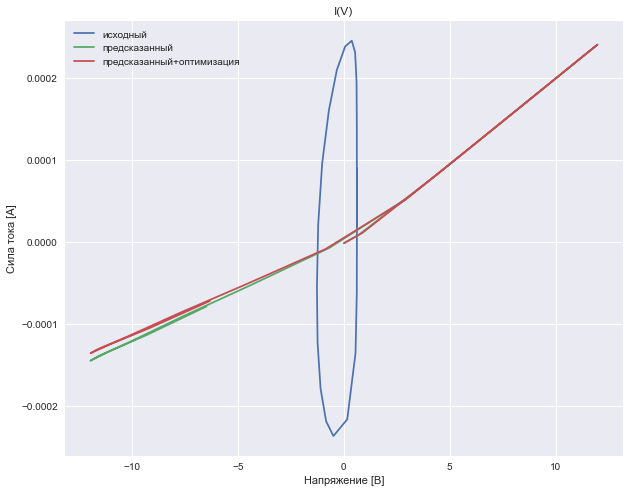

F=100000 V=12.0 lendata=20 Rcs=47500.0 cycle=3 SNR=70.0


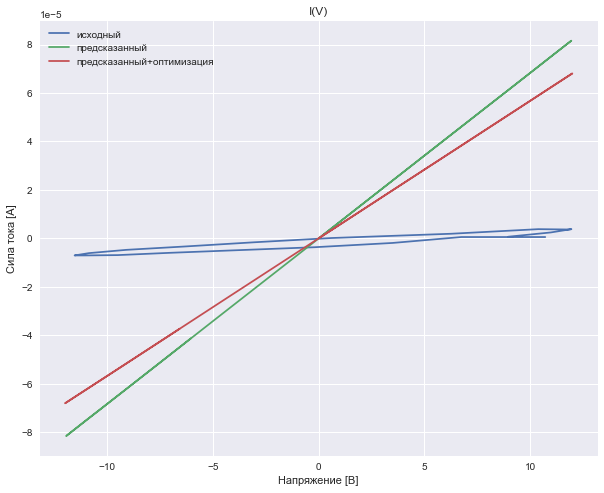

F=100000 V=12.0 lendata=20 Rcs=47500.0 cycle=3 SNR=70.0


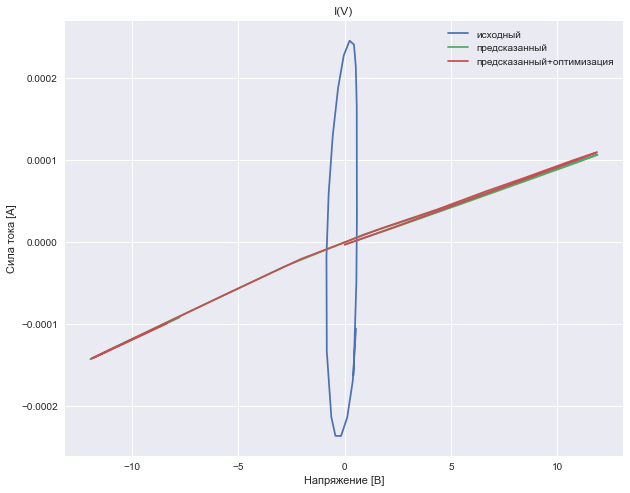

F=100000 V=12.0 lendata=20 Rcs=47500.0 cycle=3 SNR=70.0


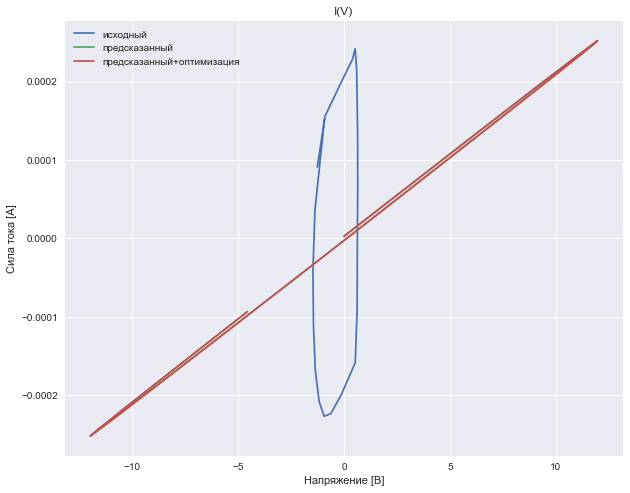

In [16]:
#%%script false
cre.test_all_json()

### Классификатор типа схемы

**file E:\EyePoint\RealSignalFolder\100hz.json
**file E:\EyePoint\RealSignalFolder\1hz_2020.json
(200,)


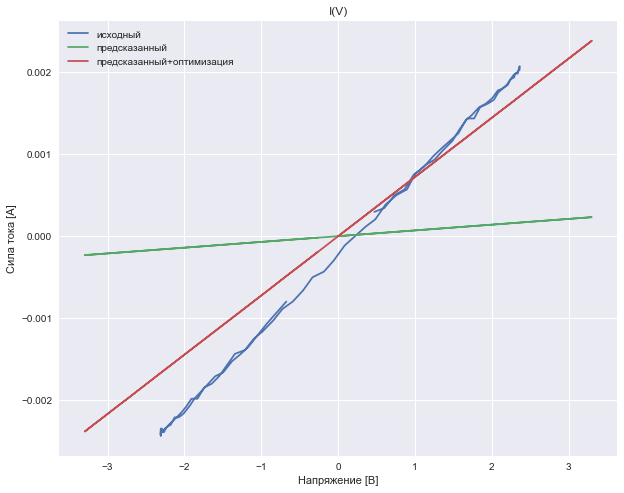

(200,)


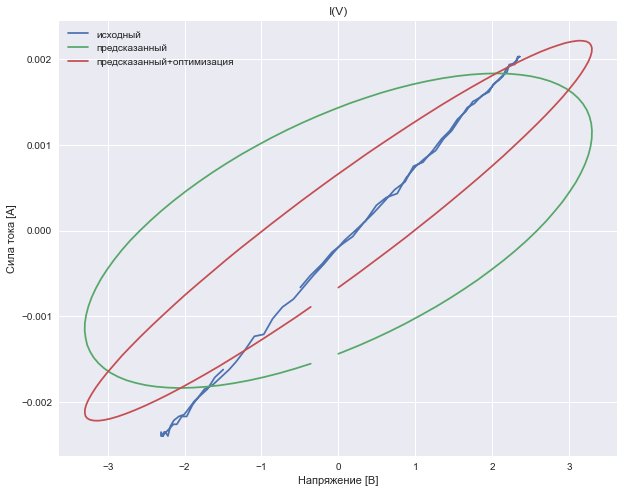

(200,)


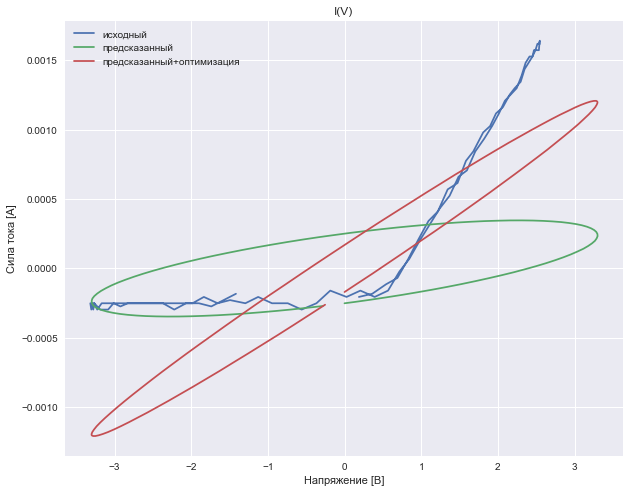

(200,)


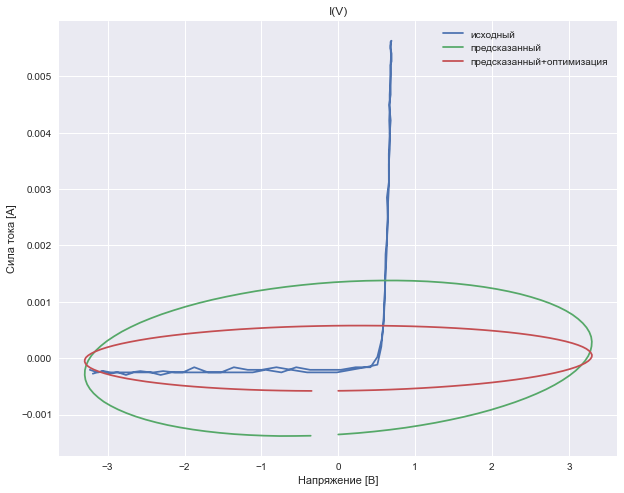

(200,)


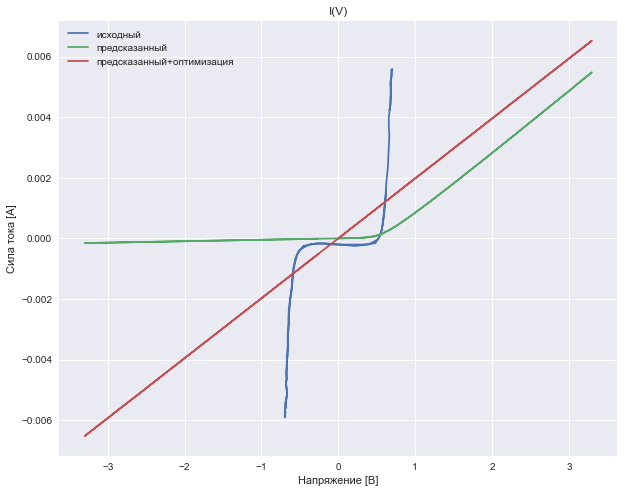

(200,)


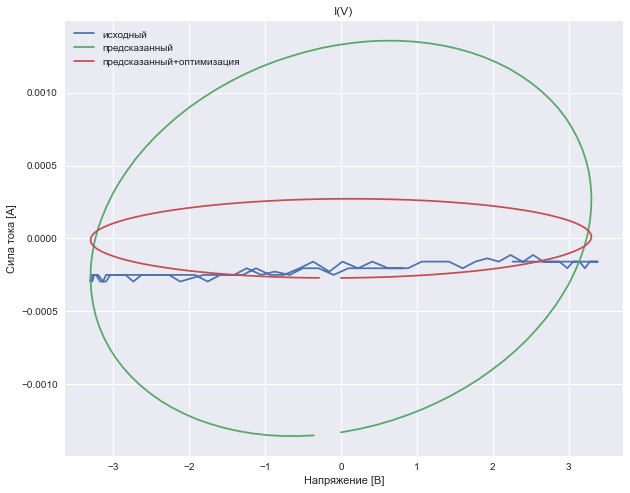

(200,)


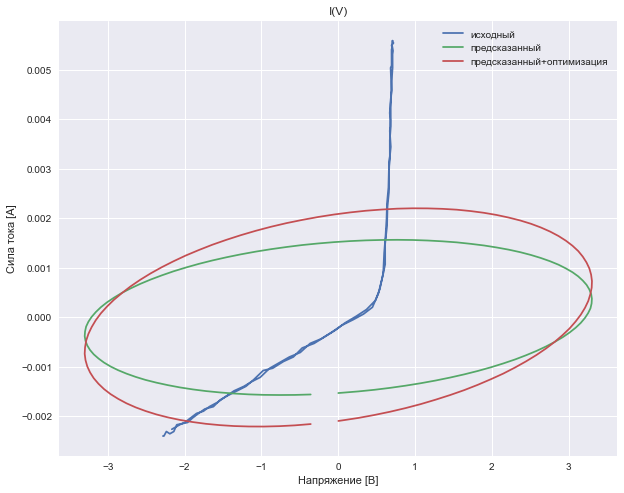

(200,)


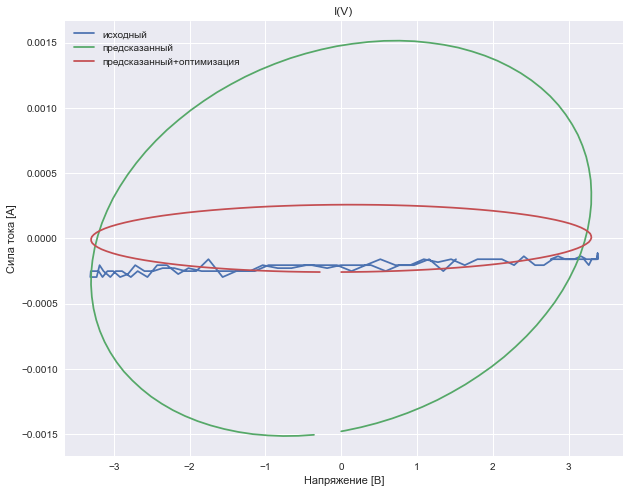

(200,)


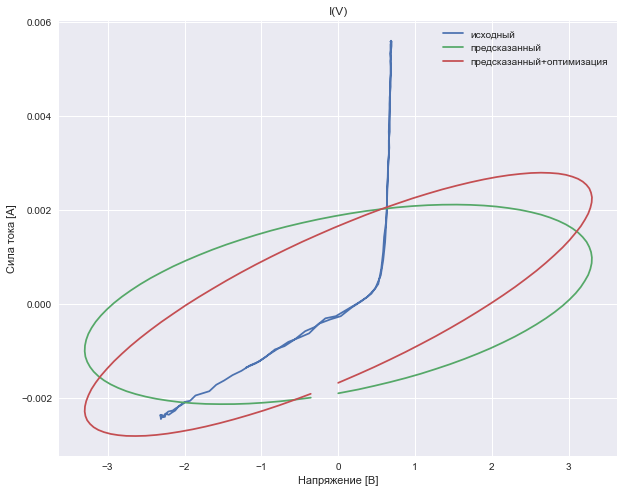

(200,)


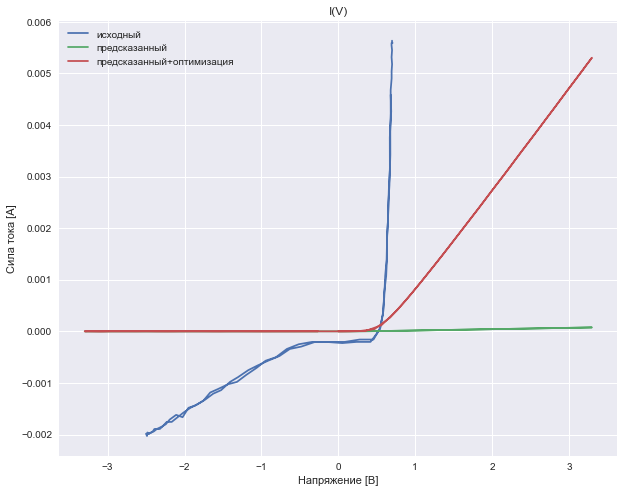

**file E:\EyePoint\RealSignalFolder\100hz_2020.json
**file E:\EyePoint\RealSignalFolder\100khz_2020.json
**file E:\EyePoint\RealSignalFolder\100hz.json
(200,)


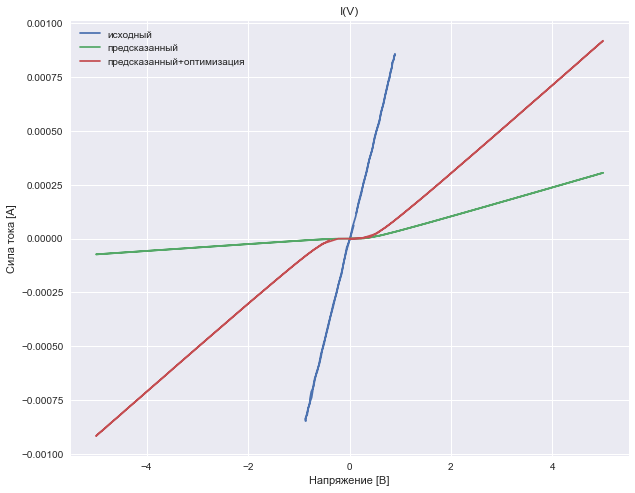

(200,)


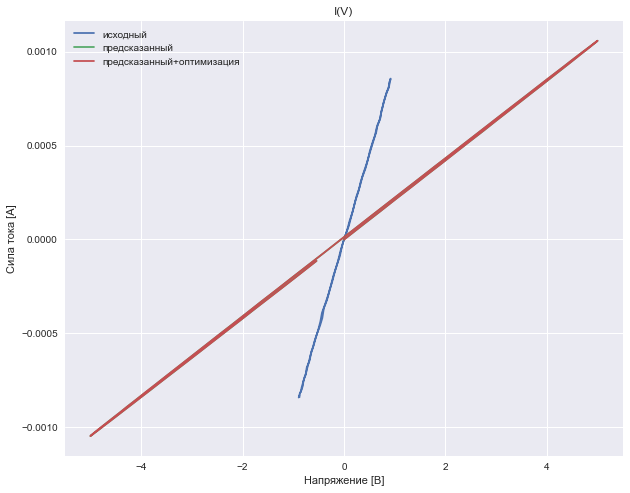

(200,)


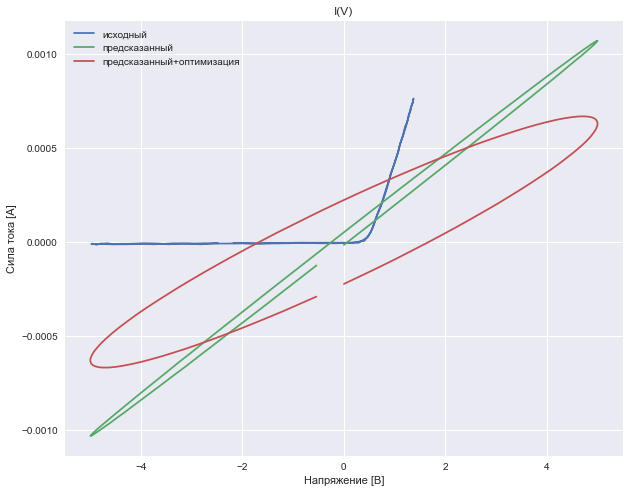

(200,)


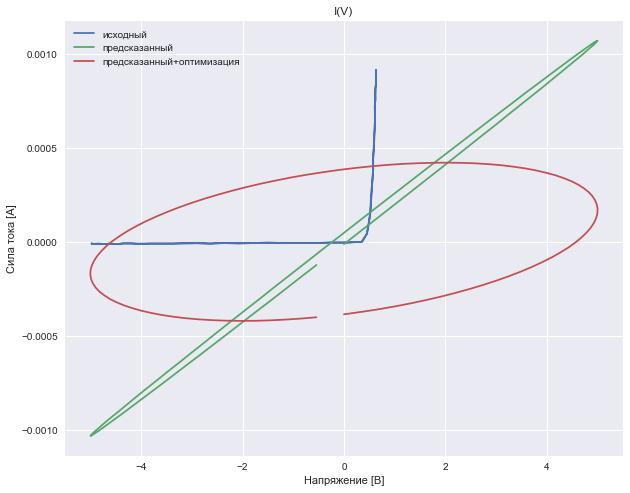

(200,)


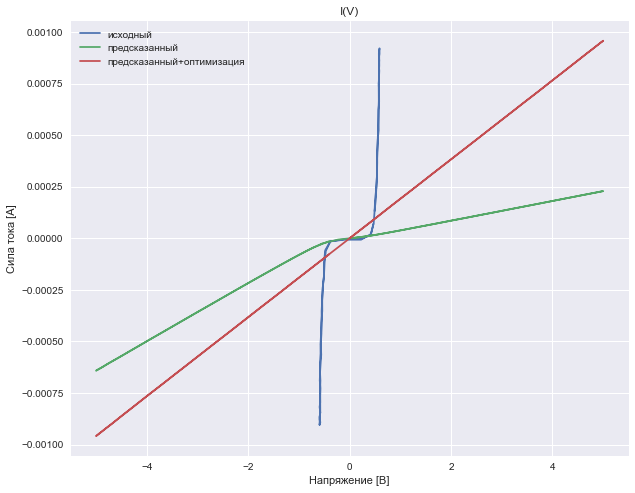

(200,)


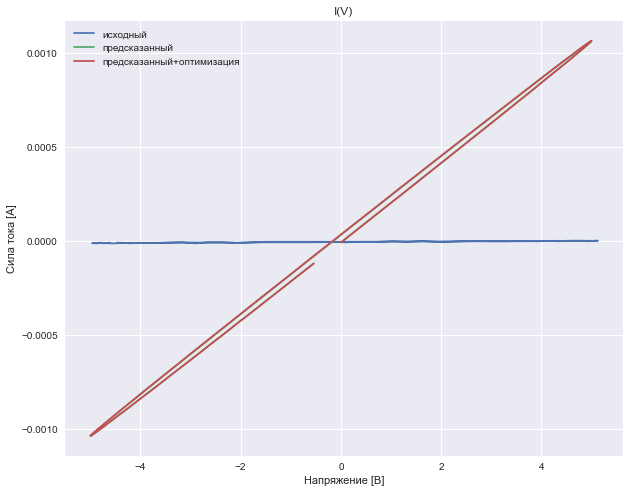

(200,)


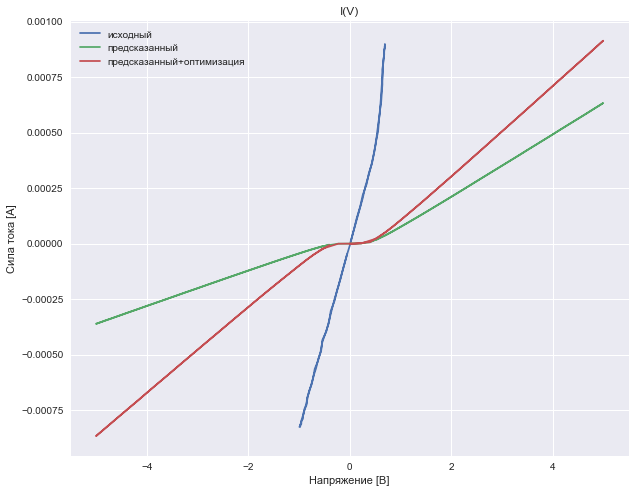

(200,)


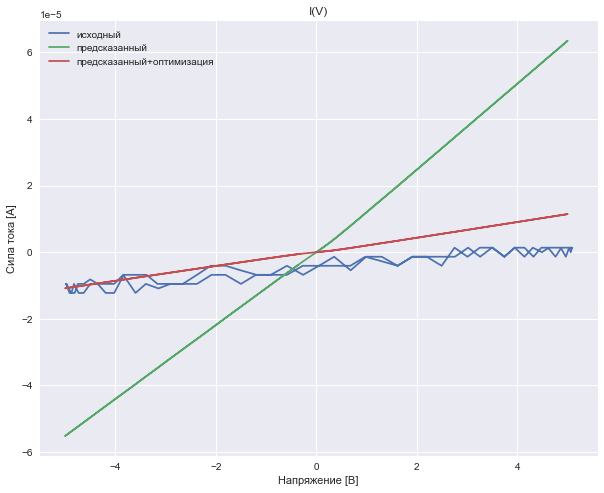

(200,)


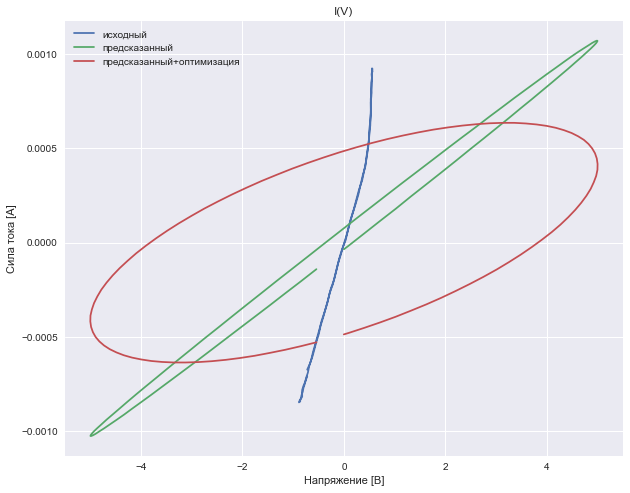

(200,)


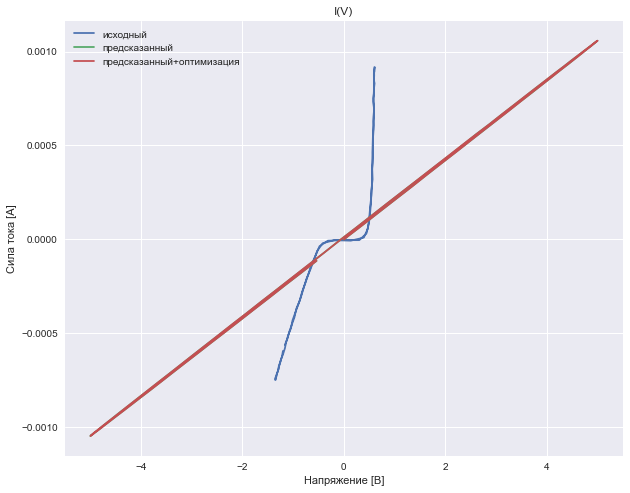

**file E:\EyePoint\RealSignalFolder\1hz_2020.json
**file E:\EyePoint\RealSignalFolder\100hz_2020.json
(200,)


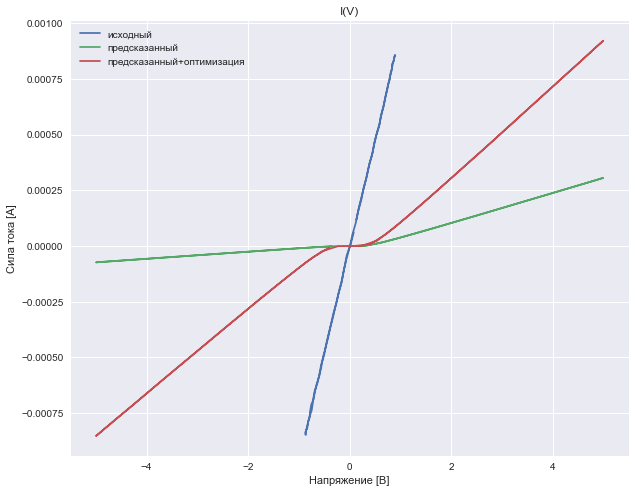

(200,)


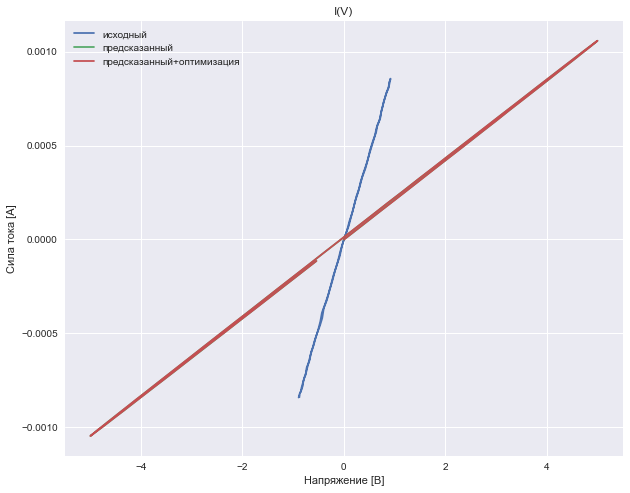

(200,)


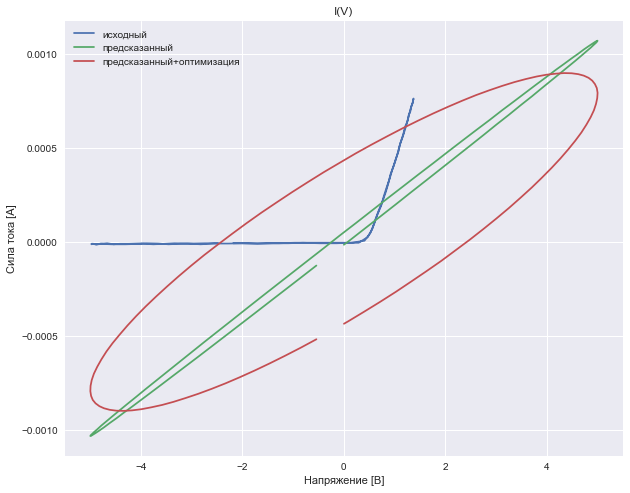

(200,)


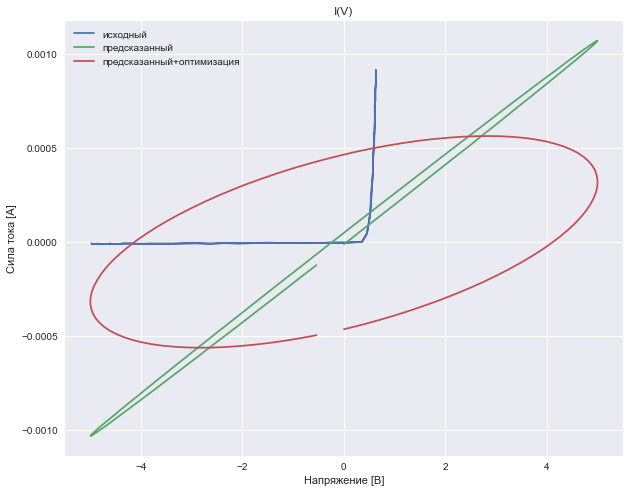

(200,)


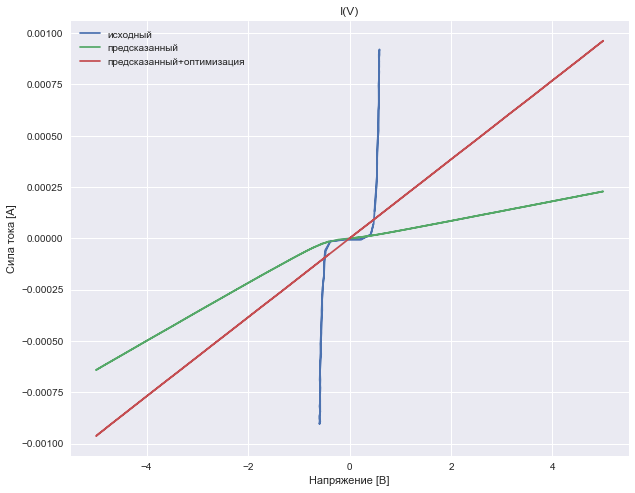

(200,)


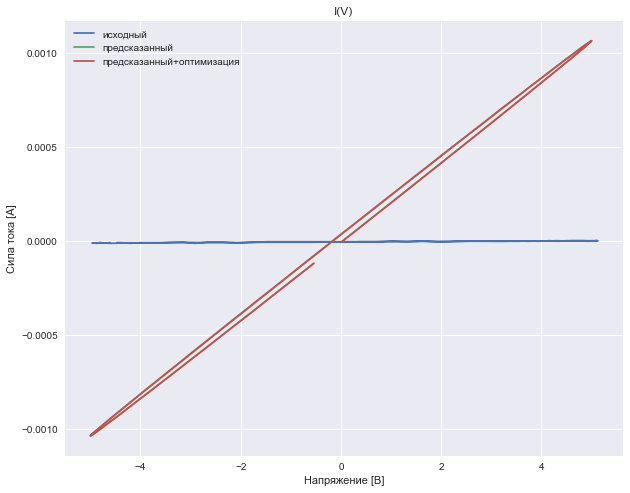

(200,)


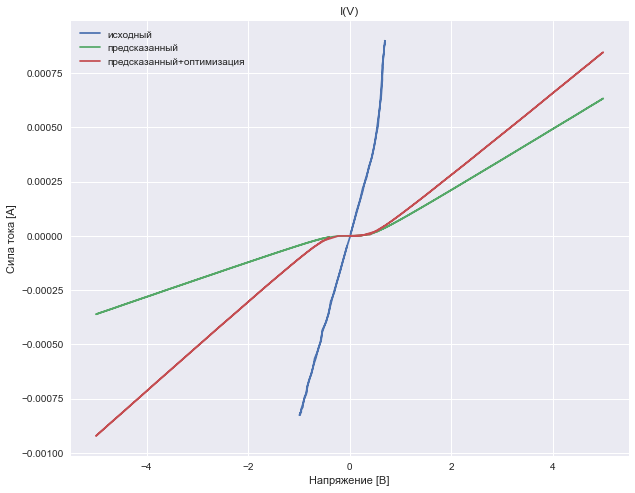

(200,)


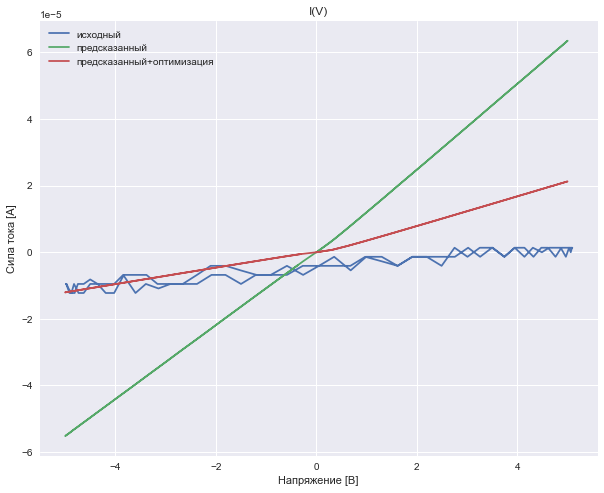

(200,)


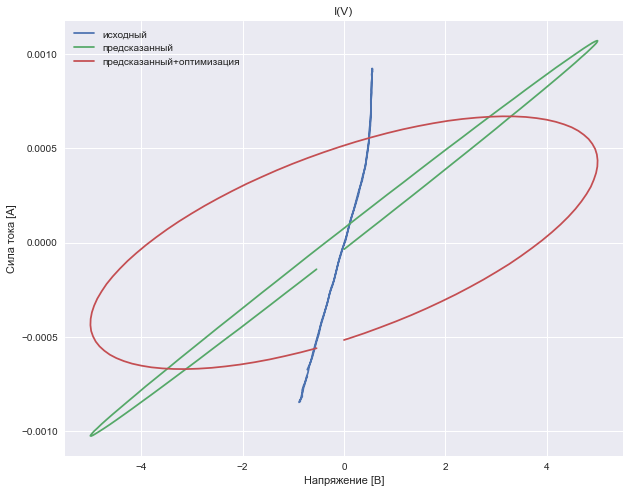

(200,)


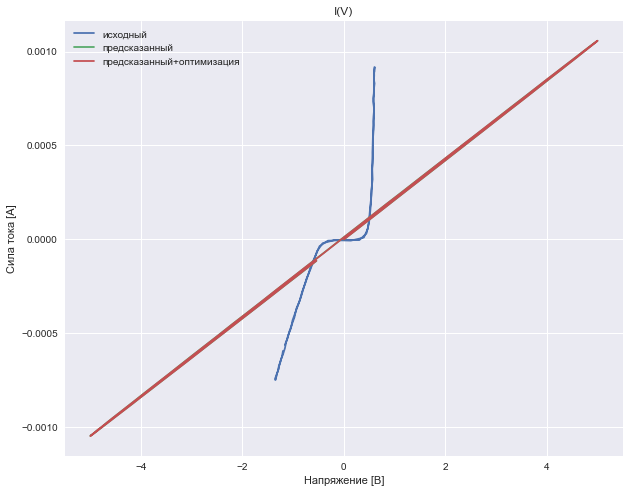

**file E:\EyePoint\RealSignalFolder\100khz_2020.json
**file E:\EyePoint\RealSignalFolder\100hz.json
**file E:\EyePoint\RealSignalFolder\1hz_2020.json
**file E:\EyePoint\RealSignalFolder\100hz_2020.json
**file E:\EyePoint\RealSignalFolder\100khz_2020.json
(40,)


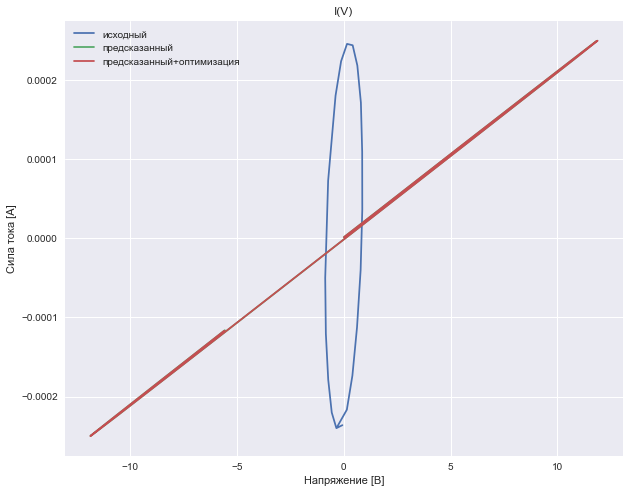

(40,)


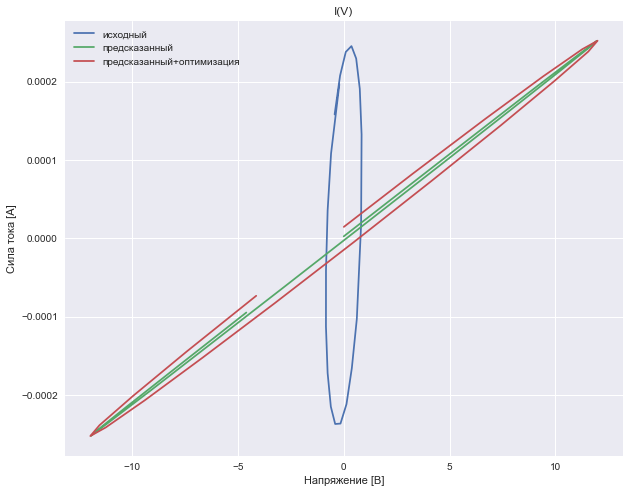

(40,)


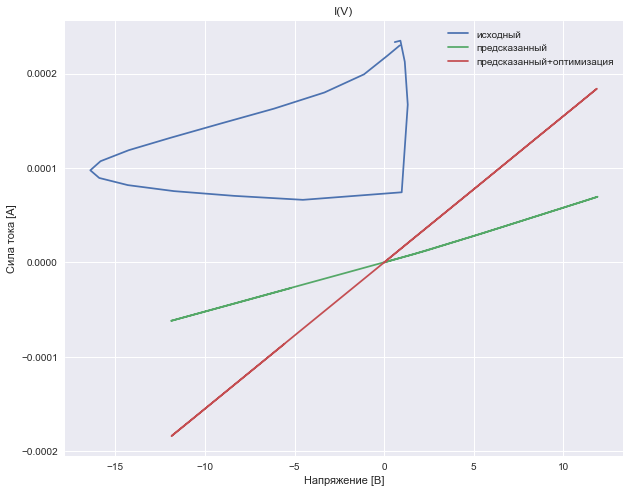

(40,)


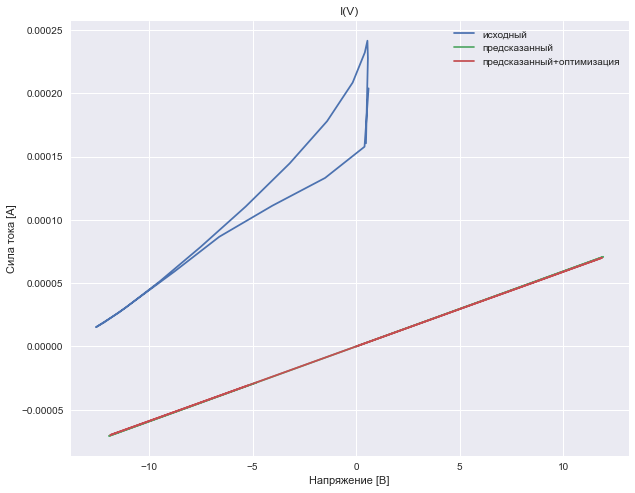

(40,)


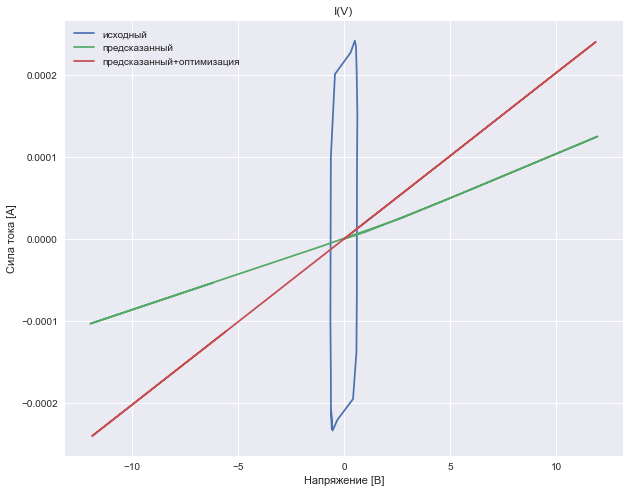

(40,)


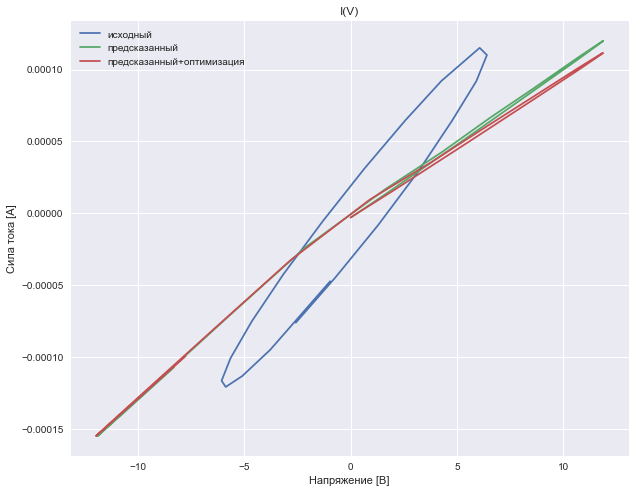

(40,)


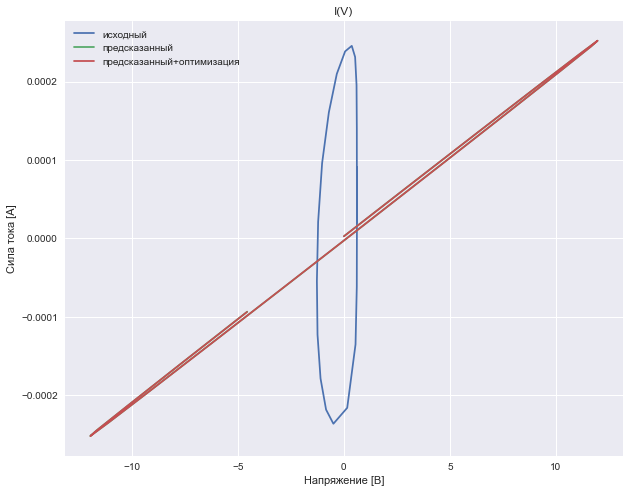

(40,)


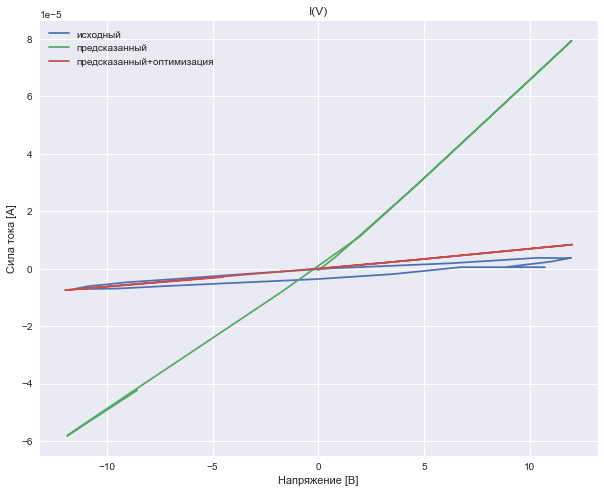

(40,)


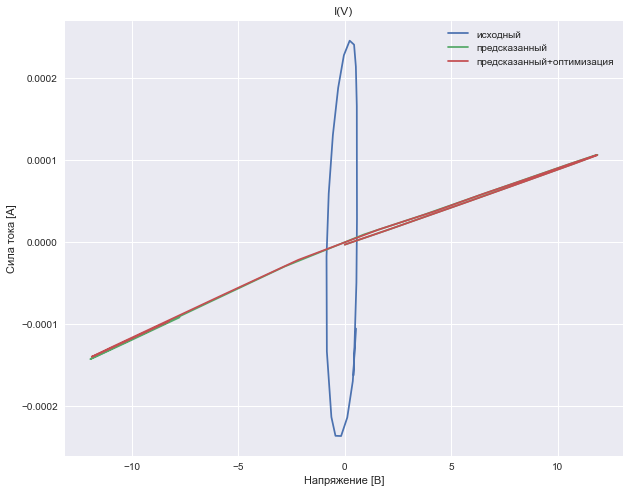

(40,)


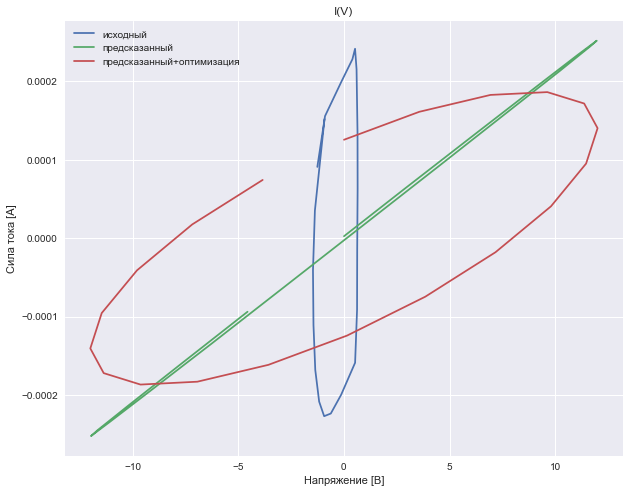

In [49]:
#%%script false
from sklearn.dummy import DummyClassifier
from sklearn.linear_model import LogisticRegression,LogisticRegressionCV
from sklearn.svm import SVC
from sklearn.ensemble import GradientBoostingClassifier,StackingClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.preprocessing import StandardScaler

class CircuitSmartPredictor():
    """ класс для классификации схемы по ВАХ"""
    def __init__(self,modelFileName,ct=None):    
        self.modelFileName = modelFileName
        self.ct = ct   
        self.c_set = []
        self.model_dirs = []
        try:
            self.load_model()
            return 
        except OSError as e:
            print(e)
            
        print('\nrebuild model ...')
        self.build_model()
        
        
    def load_model(self):
        with open(os.path.join(FILEBASE_ROOT,self.modelFileName), "rb") as f:
            self.clf_model = pickle.load(f) 
            self.ct = CurveTracer_Settings().from_numpy(self.clf_model.ct)
            self.c_set = self.clf_model.c_set
            self.model_dirs = self.clf_model.model_dirs
        
    def save_model(self):
        with open(os.path.join(FILEBASE_ROOT,self.modelFileName), "wb") as f:
            self.clf_model.ct = self.ct.to_numpy()
            self.clf_model.c_set = self.c_set
            self.clf_model.model_dirs = self.model_dirs
            pickle.dump(self.clf_model, f)
                
    
    def build_model(self):
        # выбираем только модели с подходящими настройками прибора
        for c in Circuit_Set: 
            if self.ct == c.ct:
                self.c_set.append(c)
                if c.modelDir not in self.model_dirs:
                    self.model_dirs.append(c.modelDir)
                    
        self.c_set = tuple(self.c_set)
        self.model_dirs = tuple(self.model_dirs)
        
        print('loading dataset')
        X,y = self.load_dataset()
        X_train,X_test,y_train,y_test = train_test_split(X,y)
        clf1 = make_pipeline(MyXGBTransformer,GradientBoostingClassifier())
        clf2 = SVC(kernel='linear')
        clf3 = make_pipeline(MyRfftTransformer,GradientBoostingClassifier())
        clf4 = make_pipeline(MyLinearTransformer,StandardScaler(),LogisticRegression())
        estimators = [('clf1',clf1),('clf2',clf2),('clf3',clf3),('clf4',clf4)]
        self.clf_model = StackingClassifier(estimators=estimators)
        print('model training, please wait..')
        self.clf_model.fit(X_train,y_train)
        print('clf score='+str(self.clf_model.score(X_test,y_test)))                  
        self.save_model()
        self.load_model()
        
        plt.plot(y_test)
        plt.plot(self.clf_model.predict(X_test))
        plt.show()

    
    def load_dataset(self):
        """ построить датасет для классификации. Возвращает X,y"""
        X_data,y_data = [],[]
        
        for (i,path_dataset) in (enumerate(self.model_dirs)):
            X,_ = load_circuit_dataset(path_dataset, self.ct,max_files=CLASSIFICATION_SMAPLES_COUNT)
            print(path_dataset)
            #print(X.shape)
            y2 = np.full(shape=(X.shape[0]), fill_value=i, dtype=int)
            #print(y2.shape)
            X_data.append(X)
            y_data.append(y2)
            
        X = np.vstack(X_data)
        y = np.hstack(y_data)
        
        return X.reshape(y.shape[0],-1), y
    
    def predict_circuit(self,analysis,ct):
        X = np.hstack([analysis.VCurrent,analysis.input_dummy])
        print(X.shape)
        y = self.clf_model.predict([X])
        #print(y)
        print(self.c_set[y.item()])
        return self.c_set[y.item()]
        
    def test_all_json(self):
        # просканируем папку, добавим оттуда варианты настройки прибора
        path_json = os.path.join(FILEBASE_ROOT,'RealSignalFolder')
        fileList = [f for f in os.listdir(path_json) if f.endswith('.json')]
    
        # просмотрим доступные файлы, составим множество из конфигураций прибора
        for f1 in fileList:
            ff = os.path.join(FILEBASE_ROOT,'RealSignalFolder',f1)
            print('**file '+str(ff))
            jRecs = load_JSON_Records(ff)
            for j in jRecs:
                ct0 = CurveTracer_Settings(json=j)
                if self.ct!=ct0:
                    continue
                    
                analysis0 = CAnalysis(json=j)
                objX = self.predict_circuit(analysis0,ct0)  
                # строим analysis по максимально подобранной схеме
                plot_analysis_IV(analysis0,'исходный')
                
                Xvars_2 = objX.predict_from_model(analysis0,start_minimization=False)
                analysis1 = CreateCVC(objX.build_circuit(Xvars_2),self.ct)                 
                plot_analysis_IV(analysis1,'предсказанный')
                
                Xvars_2 = objX.predict_from_model(analysis0,start_minimization=True)
                analysis2 = CreateCVC(objX.build_circuit(Xvars_2),self.ct)                 
                plot_analysis_IV(analysis2,'предсказанный+оптимизация')

    
                plt.legend()
                plt.show()

        
    
c1 = CircuitSmartPredictor('1.clf',ct_List[0])
c1.test_all_json()


c2 = CircuitSmartPredictor('2.clf',ct_List[1])
c2.test_all_json()

c3 = CircuitSmartPredictor('3.clf',ct_List[2])
c3.test_all_json()


In [ ]:
X,y 